<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D1%80%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_%D0%B4_%D0%B7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ООО "Университет Цифровых Технологий платформа 3"

# Алгоритмы кластеризации данных. Применение автокодировщиков для кластеризации. - разбор д.з.


## Загрузка необходимых модулей, объявление функций и классов

Загрузка необходимых модулей

In [ ]:
import numpy as np # Импортируем библиотеку numpy
import pandas as pd # импортируем библиотеку обработки и анализа данных pandas

from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Conv1DTranspose, Conv1D
from tensorflow.keras.layers import Reshape, Input, MaxPooling2D, Flatten, Lambda, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.objectives import binary_crossentropy
import tensorflow.keras.backend as K

#from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn import decomposition   # для импорта метода главных компонент (Principal component analysis (PCA))
from sklearn import datasets    # чтобы работать с датасетами ирисов и малых рукописных цифр
 # Импортируем библиотеку StandardScaler  для получения стандартного распределения набора данных и LabelEncoder для удобного кодирования 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier     # для классификации с помощью математического алгоритма дерева решений
from sklearn.model_selection import train_test_split    # для разделения выборок на обучение и тест
from sklearn.metrics import accuracy_score, roc_auc_score, homogeneity_score  # импортируем метрики, вторая считается более сбалансированной если есть дисбаланс классов
from sklearn.manifold import TSNE   # для визуализации многомерных данных
from sklearn.cluster import KMeans, SpectralClustering # Импортируем библиотеку KMeans для кластеризации
import time      # для оценки времени выполнения процессов
import re       # для обработки строковых переменных

import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import seaborn as sns   # Импортируем seaborn
#sns.set_style('darkgrid')
sns.set(style='white')

from mpl_toolkits.mplot3d import Axes3D # для отрисовки трёхмерных графиков

# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Объявляем функции

In [ ]:
# Создаём функцию визуализации данных
def plot_pic(X):
    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i,:].reshape([28,28]), cmap='gray')
    plt.show()

def get_start_indexes(sale_order_df): # получаем стартовые строки начала новых заказов
    mask = sale_order_df['Отгружен'].notnull() #Дата создания
    filled_idxs = list(sale_order_df[mask].index) # индексы заполненных строк, они же стартовые строки начала новых заказов
    return filled_idxs

def base_fill(sale_order_df_): # функция заполнения тех позиций в строках, которые можем заполнить:
    # sale_order_df.reset_index(inplace = True)   # устанавливаем индексы по порядку
    # В этой переменной будут все индексы строк, где есть не пустая информация в формате даты
    sale_order_df = sale_order_df_.copy()
    filled_idxs = get_start_indexes(sale_order_df) # индексы заполненных строк, они же стартовые строки начала новых заказов 
    for num, idx in enumerate(filled_idxs):     # берём индекс из индексов заполненных строк
        #print('обрабатывается индекс:', idx)
        last_idx = sale_order_df.index[-1]  # получаем последний индекс датафрейма
        last_filled_idx = filled_idxs[-1]   # получаем индекс последней заполненной строки
        if idx == last_idx:     # если этот индекс последний в таблице
            continue            # переходим к завершению цикла
        else:                   # если нет
            curr_row = sale_order_df[columns_to_fill].iloc[idx].values   # берём соответствующую заполненную строку, чтобы повторить её до следующей заполненной
            curr_idx = idx + 1 # начинаем заполнять таблицу со следующего индекса
            if idx < last_filled_idx:    # если ещё не дошли до последней заполненной строки
                while curr_idx < filled_idxs[num + 1]:  # тогда пока не дошли до следующей заполненной строки
                    sale_order_df[curr_idx:curr_idx+1][columns_to_fill] = curr_row # записываем значения в незаполненную строку , columns_to_fill
                    curr_idx +=1            # переходим к следующей строке
            else:                           # если дошли до последней заполненной строки
                while (curr_idx <= last_idx):   # пока не дошли до конца таблицы
                    sale_order_df[curr_idx:curr_idx+1][columns_to_fill] = curr_row # записываем значения в незаполненную строку
                    curr_idx +=1            # переходим к следующей строке
    sale_order_df.info()                        # проверяем, все ли пропуски заполнены
    print('Датафрейм заполнен.')
    print('число заказов:', len(filled_idxs))
    return sale_order_df # возвращаем заполненный датафрейм

def get_datetime(sale_order_df, data_column):  #парсим время
    sale_order_df[data_column] = pd.to_datetime(sale_order_df[data_column]) #переводим столбец в специальный формат даты времени
    sale_order_df['Год'] = sale_order_df[data_column].dt.year
    sale_order_df['Mесяц'] = sale_order_df[data_column].dt.month
    sale_order_df['День'] = sale_order_df[data_column].dt.day
    sale_order_df['День недели'] = sale_order_df[data_column].dt.dayofweek
    sale_order_df['Час'] = sale_order_df[data_column].dt.hour
    return sale_order_df # возвращаем заполненный датафрейм

def get_id(sale_order_df, id_column):  #парсим идентификатор
    sale_order_df['Число ID'] = sale_order_df[id_column].astype(str)
    sale_order_df['Число ID'] = sale_order_df['Число ID'].apply(lambda x: x[1:] if x[1:].isdigit()==True else None).astype(int)
    return sale_order_df # возвращаем заполненный датафрейм

def make_lab_enc(sale_order_df, column, target_col):  #кодируем позиции
    labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
    labelEncoder.fit(sale_order_df[column].unique()) # кодируем
    sale_order_df[target_col] = labelEncoder.transform(sale_order_df[column].values)
    return sale_order_df, labelEncoder # возвращаем заполненный датафрейм, объект LabelEncoder для данной колонки

def get_number_data(sale_order_df, column, target_col):  #парсим число
    sale_order_df[column] = sale_order_df[column].astype(str)
    sale_order_df[target_col] = sale_order_df[column].apply(lambda x: np.array(re.findall('\d+', x[:6].replace(']',''))[0]).astype('int32'))
    return sale_order_df # возвращаем заполненный датафрейм

def get_quantity_data(sale_order_df, column, target_col):  #парсим количество заказанного
    sale_order_df[column] = sale_order_df[column].astype(str)
    sale_order_df[target_col] = sale_order_df[column].apply(lambda x: np.array(re.findall('\d+', x[-14:])[0]).astype('int32') if len(np.array(re.findall('\d+', x[-14:])).astype('int32')) > 1 else np.array(0).astype('int32')) #14 [0]
    return sale_order_df # возвращаем заполненный датафрейм

def get_loading_data(sale_order_df, column, target_col):  #парсим результат погрузки
    sale_order_df[column] = sale_order_df[column].astype(str)
    sale_order_df[target_col] = sale_order_df[column].apply(lambda x: x[6:])
    return sale_order_df # возвращаем заполненный датафрейм

def get_payment_data(sale_order_df, column, target_col):  #парсим результат оплаты
    sale_order_df[column] = sale_order_df[column].astype(str)
    sale_order_df[target_col] = sale_order_df[column].apply(lambda x: x[8:-15])
    return sale_order_df # возвращаем заполненный датафрейм

def stats(data): # функция вывода статистик по кластеру
    print("Размер кластера:", data.shape[0]) # Выведем количество элементов в кластере
  
    mean = np.mean(data, axis=0)  # Считаем среднее значение по кластеру
    min = np.min(data, axis=0) # Находим минимальное значение в кластере
    max = np.max(data, axis=0) # Находим максимальное значение в кластере
    std = np.std(data, axis=0) # Находим стандартное отклонение элементов кластера

    # Отображаем полученную информацию по указанному кластеру
    print('в кластер попали:')
    print('#########################################')
    print()
    print("статистические данные по столбцам:")
    print("-----------------------------------------")

    for idx, name in enumerate(columns):
        print(name, ": диапазон", min[idx], "-", max[idx], "среднее значение:", mean[idx], "разброс:", std[idx],  sep="\t")
        plt.hist(data[:,idx], 20, label=name)
        plt.legend()
        plt.show()
        print()

def get_carts(sale_order_df, filled_idxs, column): # функция формирования корзин, по столбцу '№ позиции'
    all_carts = []  # здесь будет список всех корзин
    carts_lens = [] # здесь будут размеры всех корзин
    for num, idx in enumerate(filled_idxs):     # берём индекс из индексов заполненных строк
        curr_cart = []  # это будет текущая корзина
        #print('обрабатывается индекс:', idx)
        last_idx = sale_order_df.index[-1]  # получаем последний индекс датафрейма
        last_filled_idx = filled_idxs[-1]   # получаем индекс последней заполненной строки
        if idx == last_idx:     # если этот индекс последний в таблице
            curr_cart.append(sale_order_df[column].iloc[idx]) # формируем последнюю корзину из одной строки
            #continue            # переходим к завершению цикла
        else:                   # если нет
            curr_cart.append(sale_order_df[column].iloc[idx])   # берём значение ячейки нужного столбца, добавляем в текущую корзину
            curr_idx = idx + 1 # начинаем заполнять таблицу со следующего индекса
            if idx < last_filled_idx:    # если ещё не дошли до последней заполненной строки
                while curr_idx < filled_idxs[num + 1]:  # тогда пока не дошли до следующей заполненной строки
                    curr_cart.append(sale_order_df[column].iloc[curr_idx])   # берём значение ячейки нужного столбца, добавляем в текущую корзину
                    curr_idx +=1            # переходим к следующей строке
            else:                           # если дошли до последней заполненной строки
                while (curr_idx <= last_idx):   # пока не дошли до конца таблицы
                    curr_cart.append(sale_order_df[column].iloc[curr_idx])   # берём значение ячейки нужного столбца, добавляем в текущую корзину
                    curr_idx +=1            # переходим к следующей строке
        all_carts.append(curr_cart)
        carts_lens.append(len(curr_cart))
    print('все корзины заполнены.')
    print('число заказов:', len(filled_idxs), '; число корзин:', len(all_carts), sep = '')
    print('минимальный размер корзины:', sorted(carts_lens)[0], ', максимальный размер корзины:', sorted(carts_lens)[-1], sep = '')
    print('гистограмма корзин по размерам:')
    plt.hist(carts_lens, 20, label='количество корзин по размерам')
    plt.legend()
    plt.show()
    return all_carts # возвращаем заполненный список корзин

def get_product_name(sale_order_df, id_column, target_col): # создаём список уникальных имён товаров из колонки 'Позиции', соответствующих ID в колонке '№ позиции'
    unique_products = {}    # в этом словаре ключами будут номера уникальных товаров, значениями - их наименования
    unique_nums = sale_order_df[id_column].unique() # получаем список уникальных id товаров
    for num in unique_nums: # берём уникальный номер
        for idx, value in enumerate(sale_order_df[target_col].values):  # берём индекс и наименование товара из колонки с названиями товаров
            if sale_order_df[id_column].iloc[idx] == num: # если спарсенный ранее id из колонки соответствует уникальному номеру 
                unique_products[num] = value[:-10]  # берём название вместе с указанным перед ним id
    return unique_products  # возвращаем словарь имён 

def get_products_from_cart(cart, unique_products):  # функция вывода на печать id и наименований товаров из корзины
    for prod in cart:   # берём один id из корзины
        print(unique_products[prod])    # выводим на печать соответствующее ему наименование

def convert_to_01(idxs, max_count): #функция преобразования вектора по приницпу bag of words
  out = np.zeros(max_count)                   # Создаем вектор из нулей длинной max_count
  for idx in idxs:                        # Пробегаем по всем индексам в idxs
    out[idx] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор  из 0 и 1

def convert_set_to_01(dataset, max_count):   #функция преобразования выборки данных по принципе Bag of words
  out = []                                     # Создаем пустой список  
  for idxs in dataset:                           # Пробегаем по всем элементам выборки
    out.append(convert_to_01(idxs, max_count))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку  из 0 и 1

# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='MSE на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='MSE на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

# Домашнее задание

##Базовый

Запустите код с занятия. Изменяя random_state от 0 до 99 включительно, попробуйте подобрать состояние, при котором сочетание алгоритма t-SNE даёт наилучшую классификацию рукописных цифр с использованием K-means.

Снижение размерности данных рукописных цифр

In [ ]:
import tensorflow as tf
(X, y), (_, _) = tf.keras.datasets.mnist.load_data()
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X = X[:2000]
y = y[:2000]
X.shape

(2000, 784)

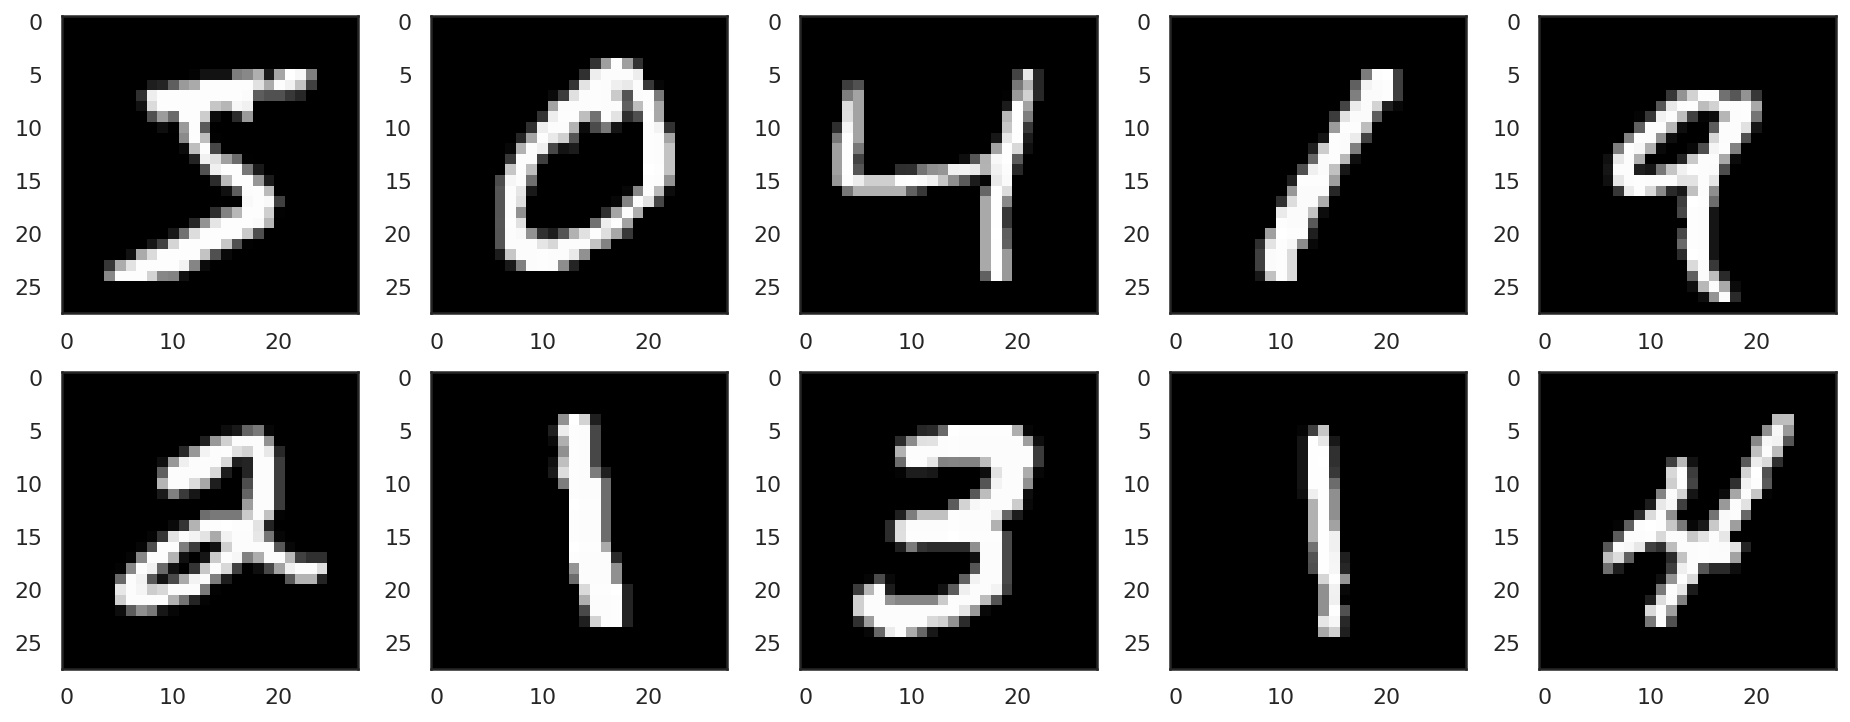

In [ ]:
plot_pic(X)

In [ ]:
clusters_count = 10             # Задаем количество кластеров
for seed in range(100):

    tsne = TSNE(random_state=seed) #17
    X_tsne = tsne.fit_transform(X)
    
    kmean = KMeans(clusters_count)  # Создаем объект KMeans с указанным количеством кластеров
    kmean.fit(X_tsne)               # Произвдим кластеризацию данных xTrain01Scaled
    pred = kmean.predict(X_tsne)
    print('seed = ', seed, 'верных ответов',round(100*homogeneity_score(y, pred),2), '%')

seed =  0 верных ответов 61.91 %
seed =  1 верных ответов 60.3 %
seed =  2 верных ответов 59.78 %
seed =  3 верных ответов 61.25 %
seed =  4 верных ответов 61.74 %
seed =  5 верных ответов 61.42 %
seed =  6 верных ответов 60.4 %
seed =  7 верных ответов 60.32 %
seed =  8 верных ответов 60.53 %
seed =  9 верных ответов 60.42 %
seed =  10 верных ответов 59.92 %
seed =  11 верных ответов 59.94 %
seed =  12 верных ответов 61.3 %
seed =  13 верных ответов 60.93 %
seed =  14 верных ответов 59.97 %
seed =  15 верных ответов 62.06 %
seed =  16 верных ответов 58.28 %
seed =  17 верных ответов 60.33 %
seed =  18 верных ответов 60.46 %
seed =  19 верных ответов 59.61 %
seed =  20 верных ответов 59.65 %
seed =  21 верных ответов 62.75 %
seed =  22 верных ответов 61.36 %
seed =  23 верных ответов 59.79 %
seed =  24 верных ответов 61.94 %
seed =  25 верных ответов 61.82 %
seed =  26 верных ответов 62.61 %
seed =  27 верных ответов 60.93 %
seed =  28 верных ответов 62.52 %
seed =  29 верных ответов 6

Проверяем повторяемость результата:

In [ ]:
clusters_count = 10
seed = 31
tsne = TSNE(random_state=seed) #17
X_tsne = tsne.fit_transform(X)
    
kmean = KMeans(clusters_count)  # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(X_tsne)               # Произвдим кластеризацию данных xTrain01Scaled
pred = kmean.predict(X_tsne)
print('seed = ', seed, 'верных ответов',round(100*homogeneity_score(y, pred),2), '%')

seed =  31 верных ответов 62.75 %


##Основной

Рассмотрите алгоритмы кластеризации, которые присутствуют в библиотеке scikit learn, и попробуйте подобрать такое сочетание алгоритма и его настройки, которое улучшит кластеризацию рукописных цифр (по желанию - либо всё можно сделать на средствах бибилиотеки, либо провести кластеризацию после автокодировщика), повысив процент на метрике. 

Возьмём SpectralClustering, как один из наиболее удачных алгоритмов. Нужно иметь ввиду, что с ростом количества данных, заметно возрастает время обработки.

In [ ]:
# берём результат подбора из базового задания
seed = 31

tsne = TSNE(random_state=seed)
X_tsne = tsne.fit_transform(X)

In [ ]:
# Создаём и обучаем объект SpectralClustering
sc = SpectralClustering(n_clusters=clusters_count, gamma=0.145)  # Создаем объект с указанным количеством кластеров

clustering = sc.fit(X_tsne)               # Произвдим кластеризацию данных X_tsne

In [ ]:
# Получаем прогноз меток и сравниваем метрикой
pred = clustering.labels_
print('верных ответов',round(100*homogeneity_score(y, pred),2), '%')

верных ответов 63.14 %


In [ ]:
pred.shape

(2000,)

выводим кластер № 0


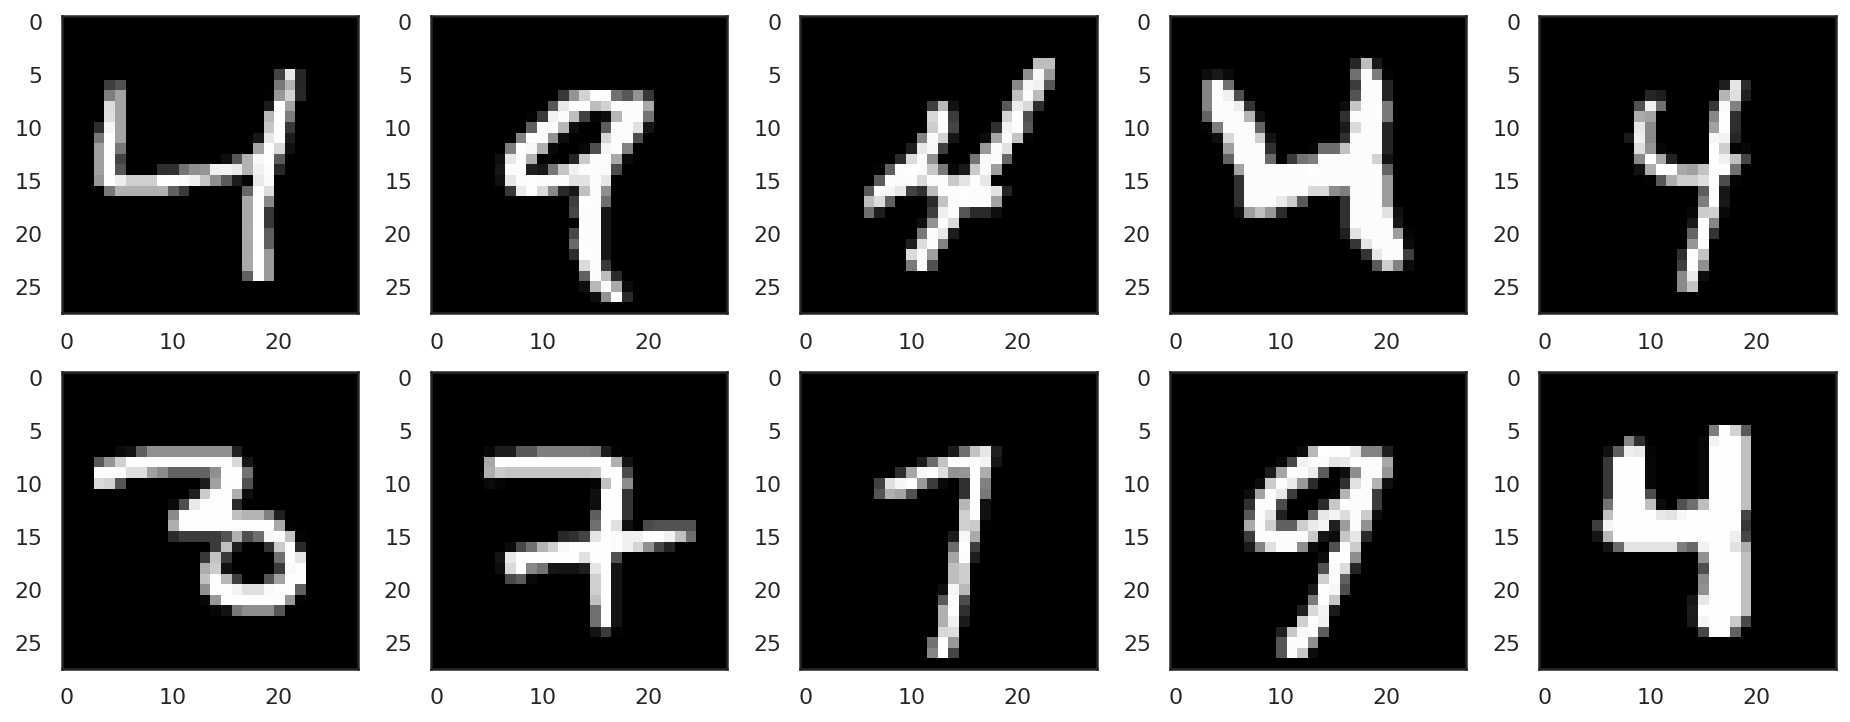


выводим кластер № 1


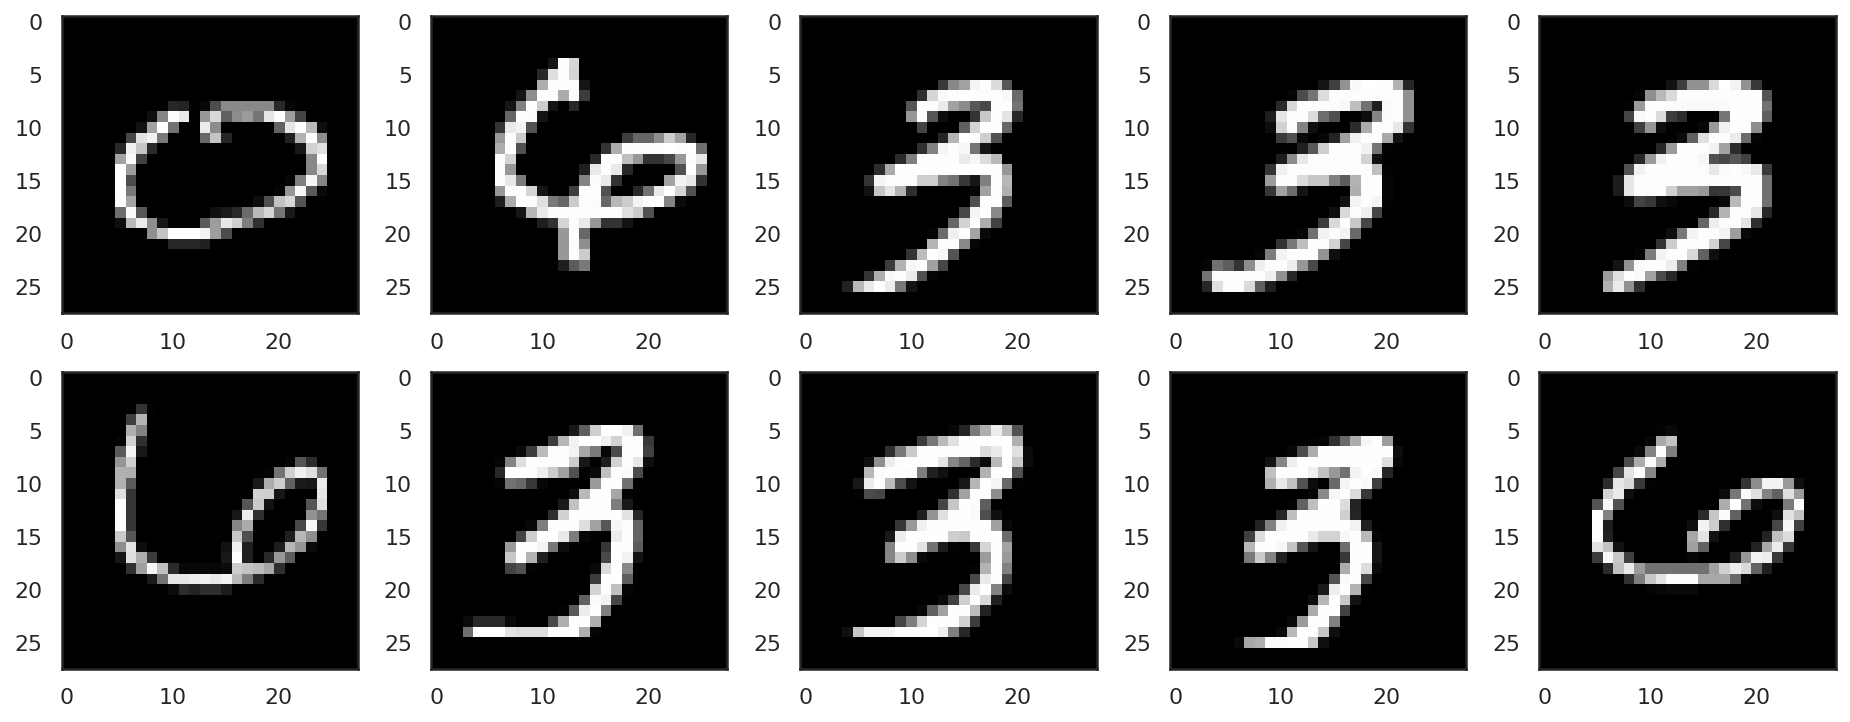


выводим кластер № 2


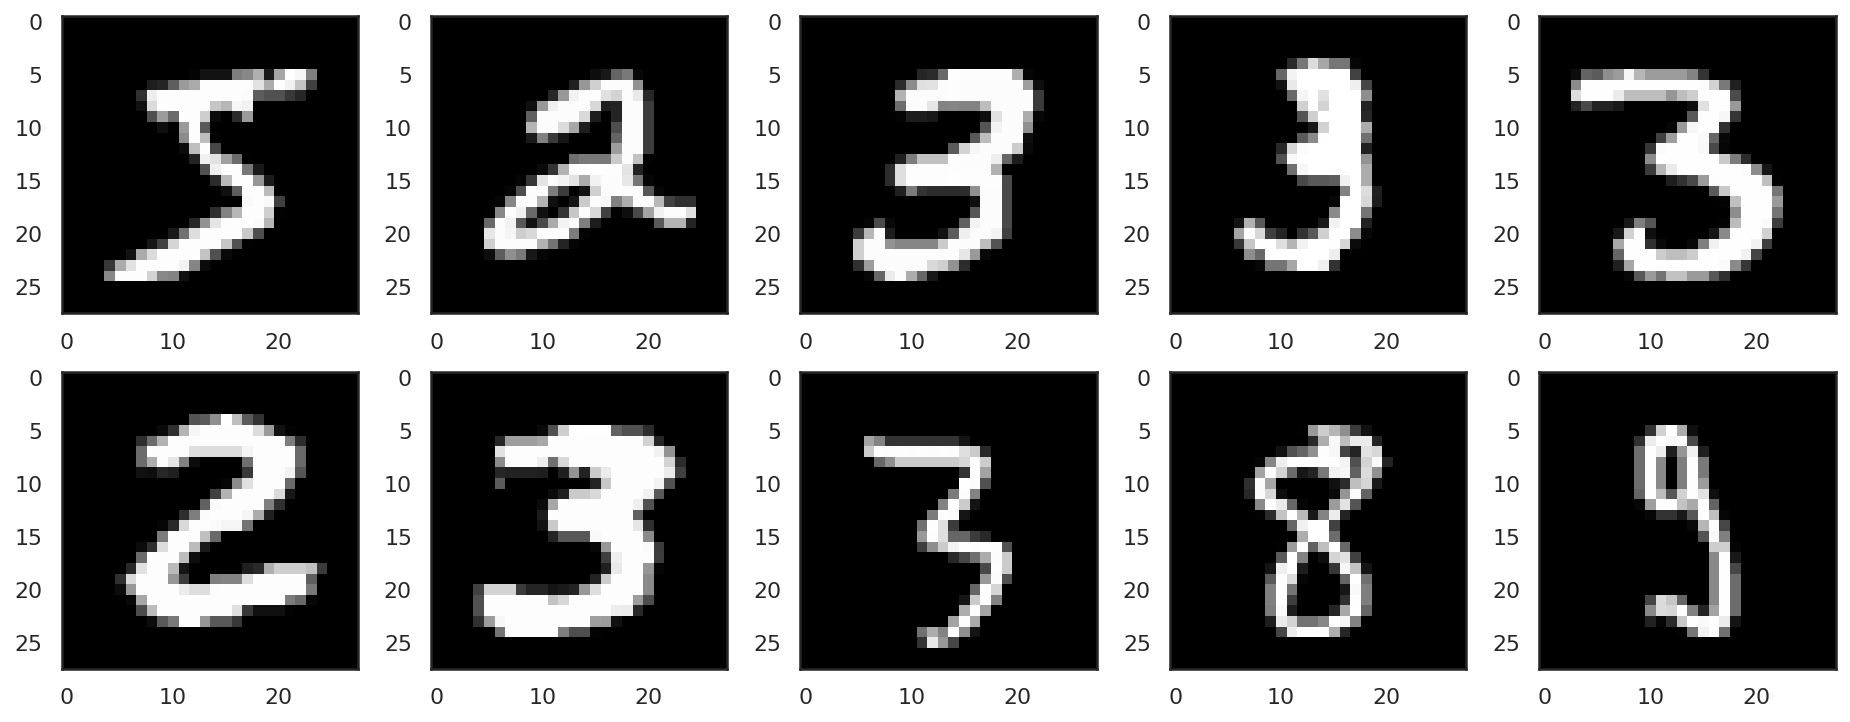


выводим кластер № 3


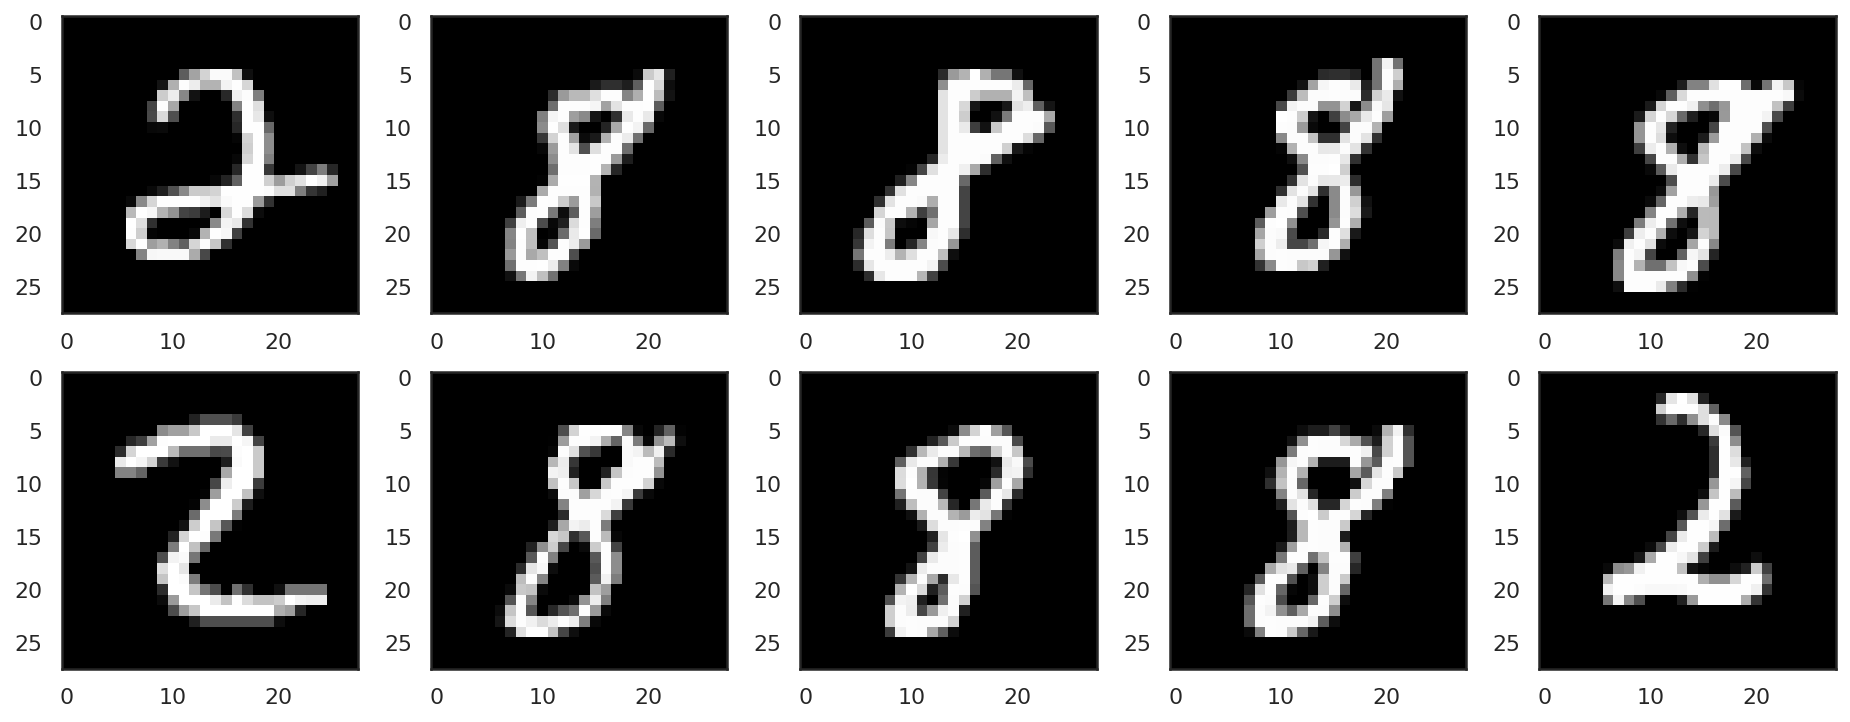


выводим кластер № 4


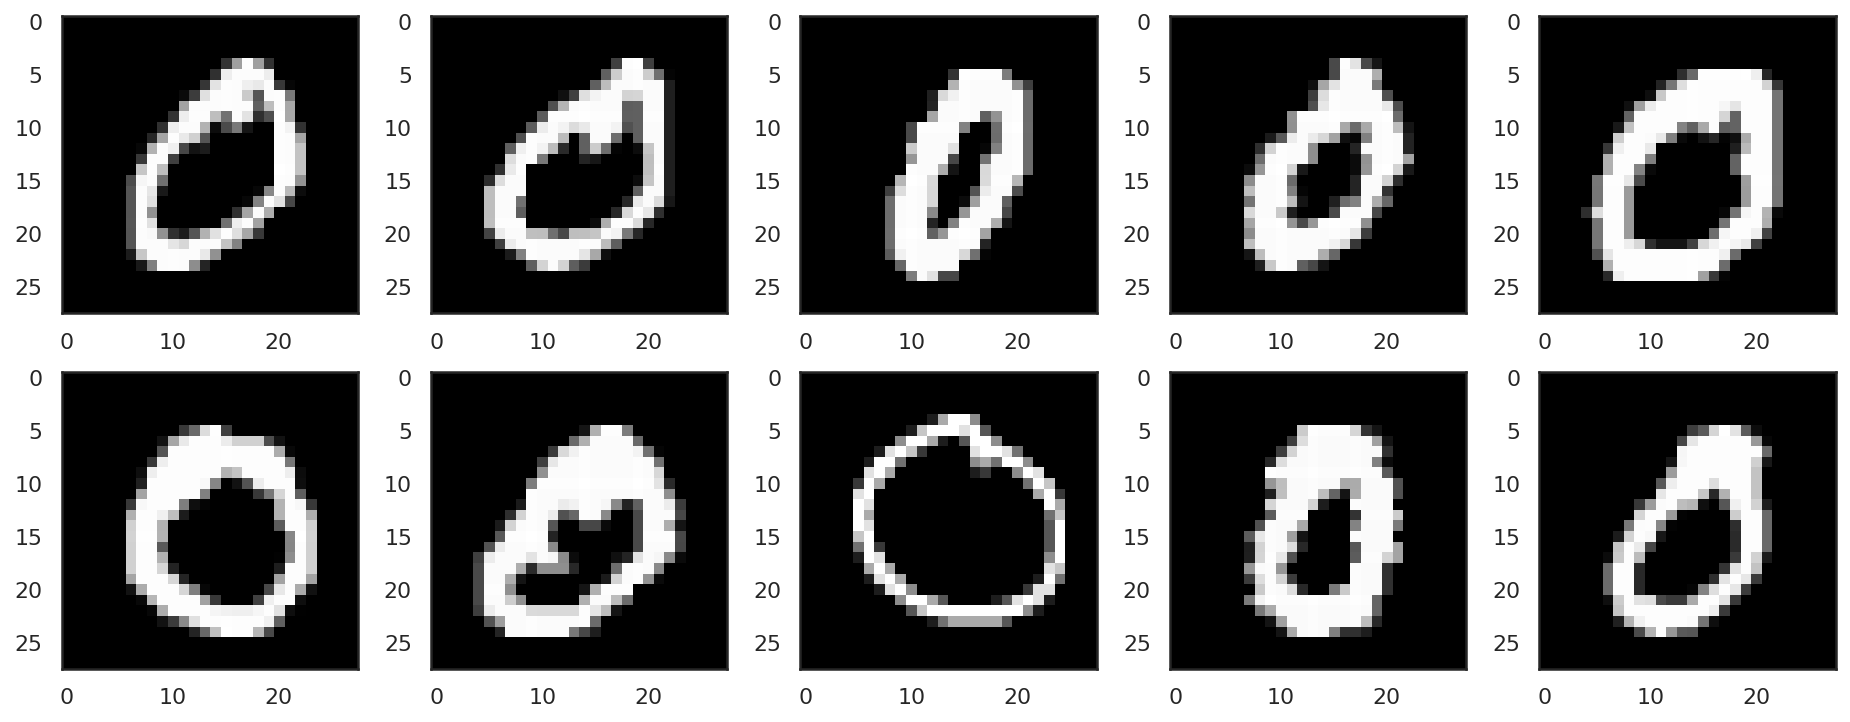


выводим кластер № 5


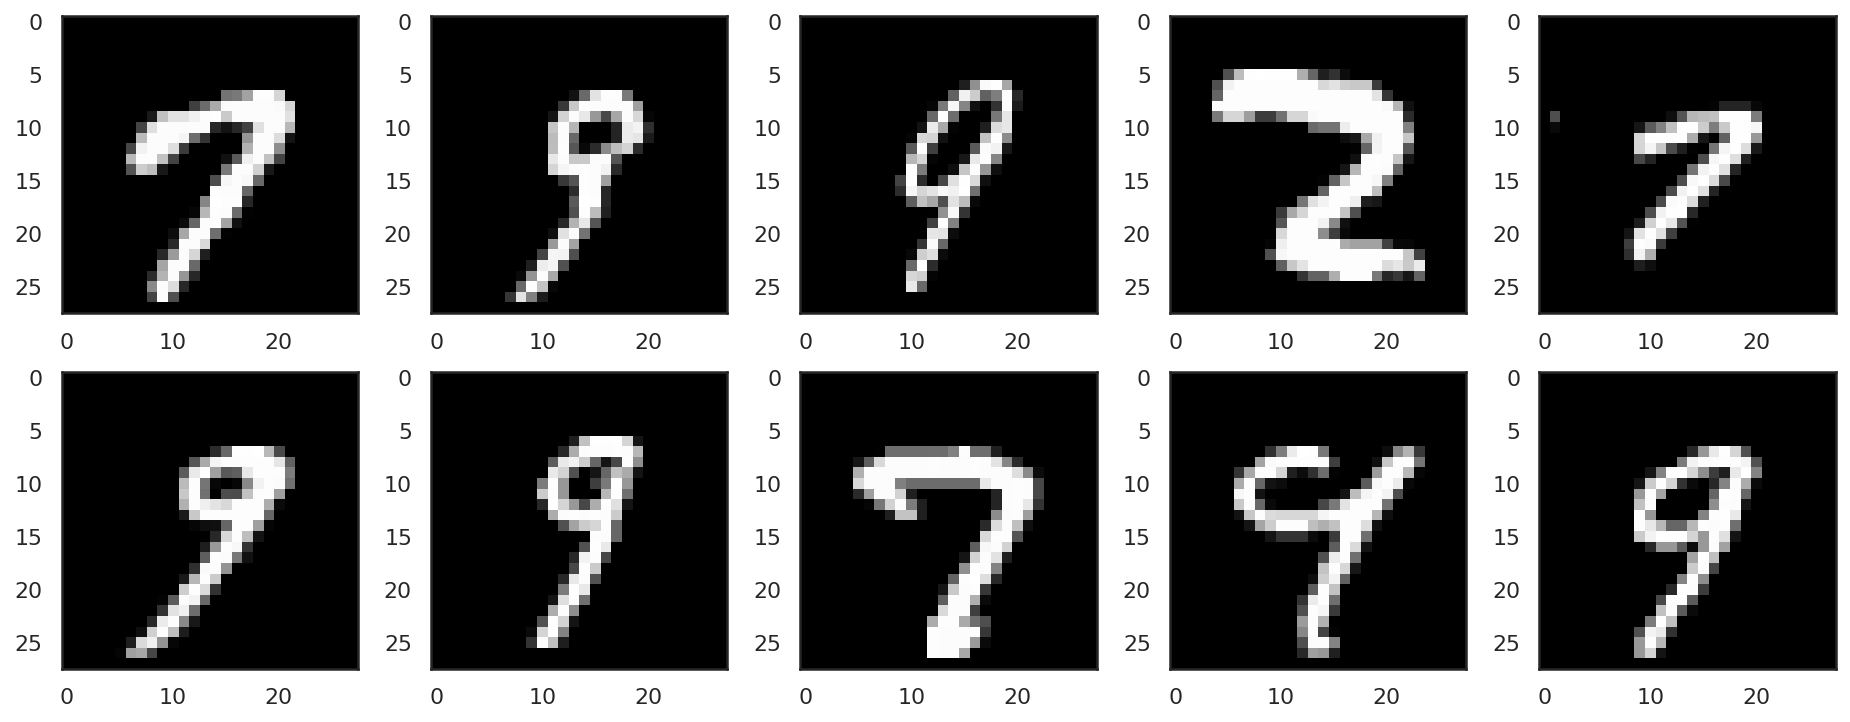


выводим кластер № 6


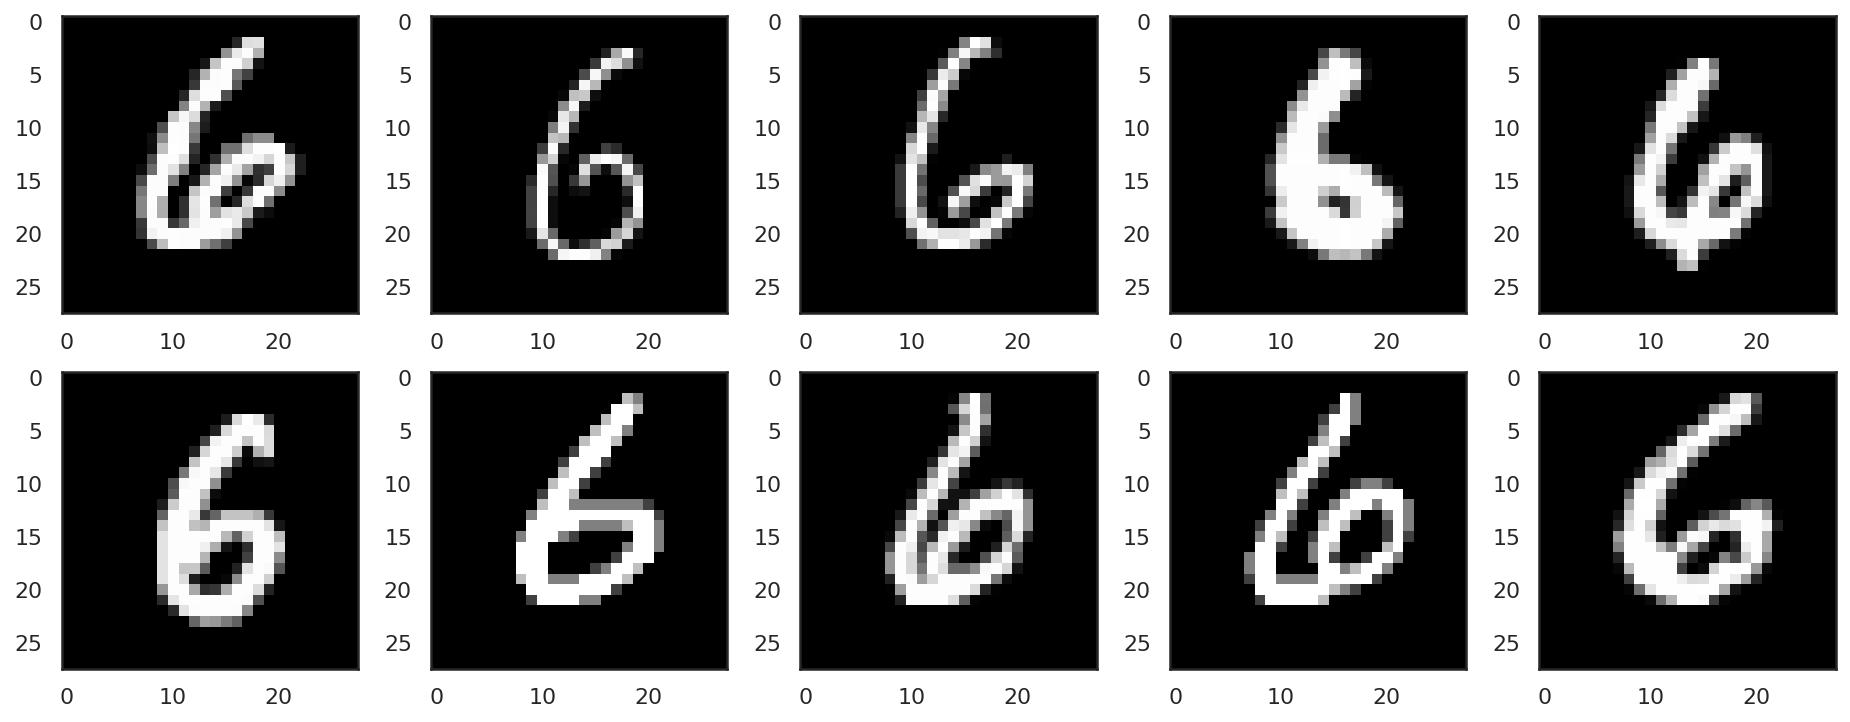


выводим кластер № 7


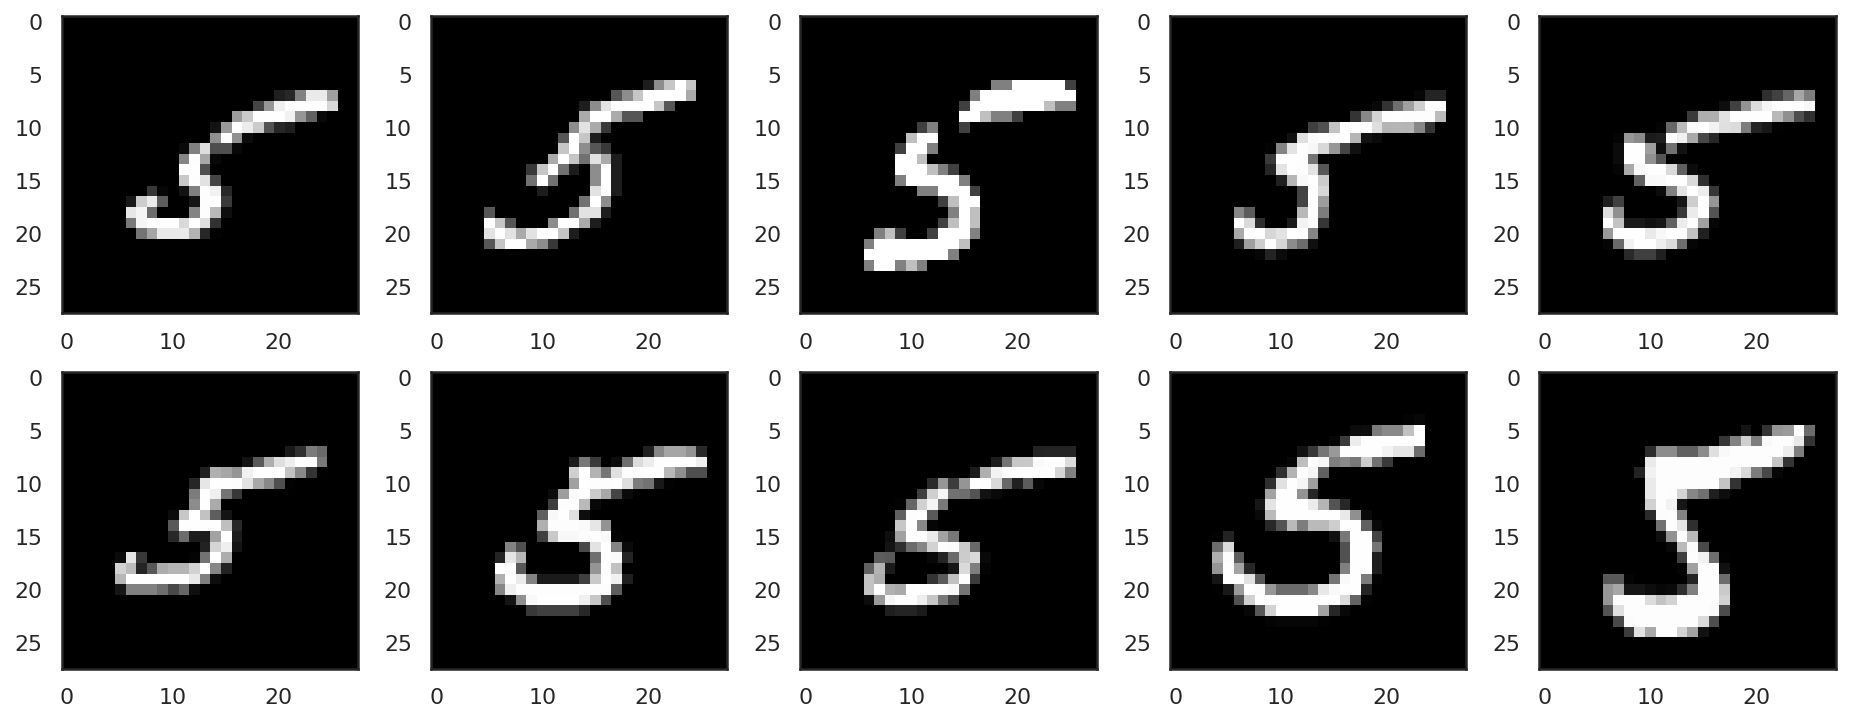


выводим кластер № 8


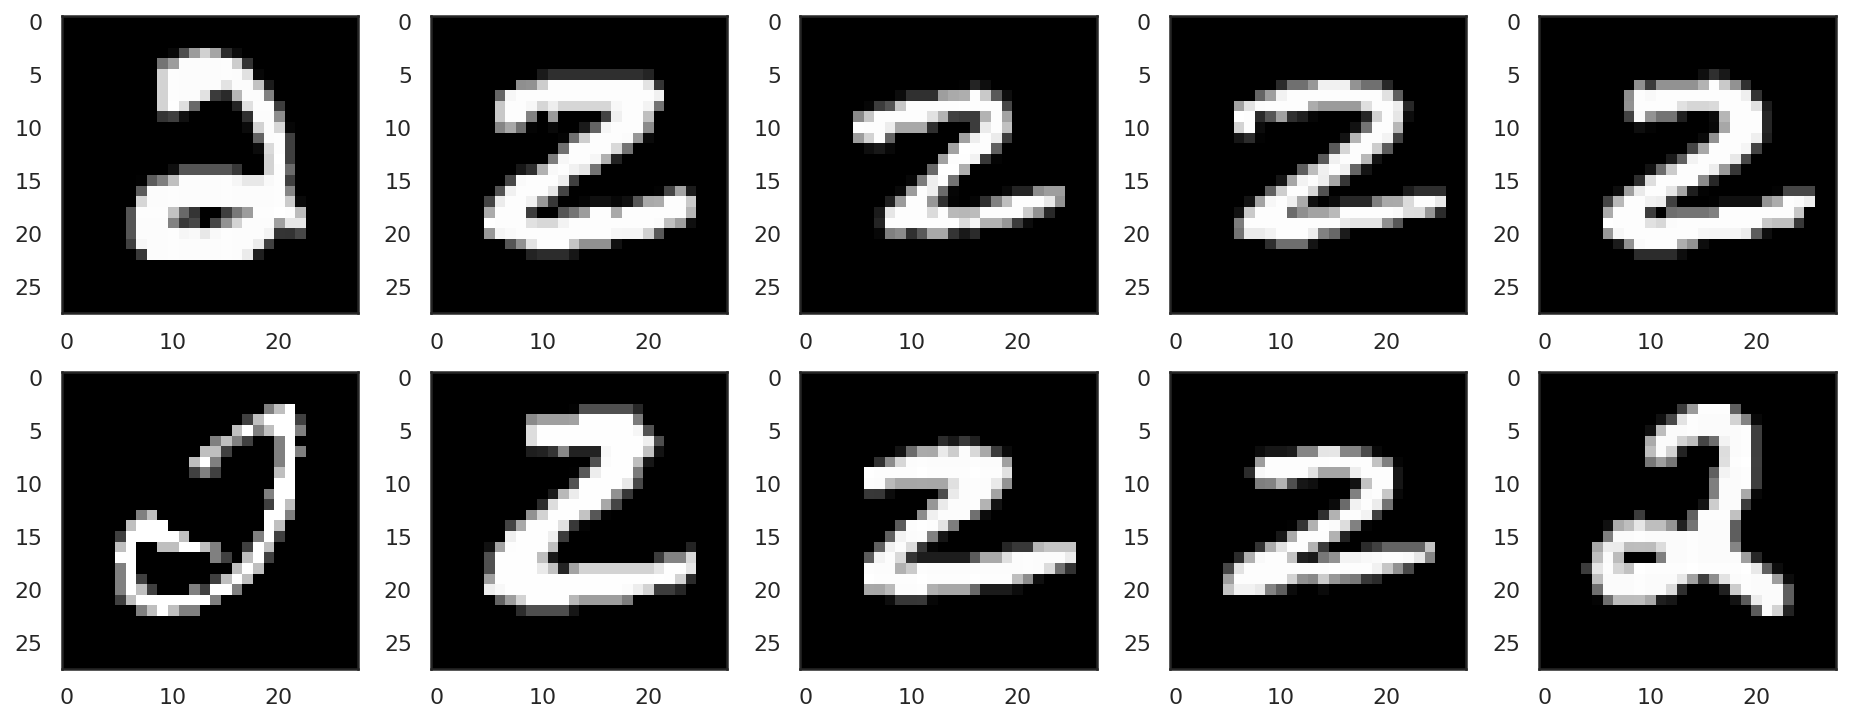


выводим кластер № 9


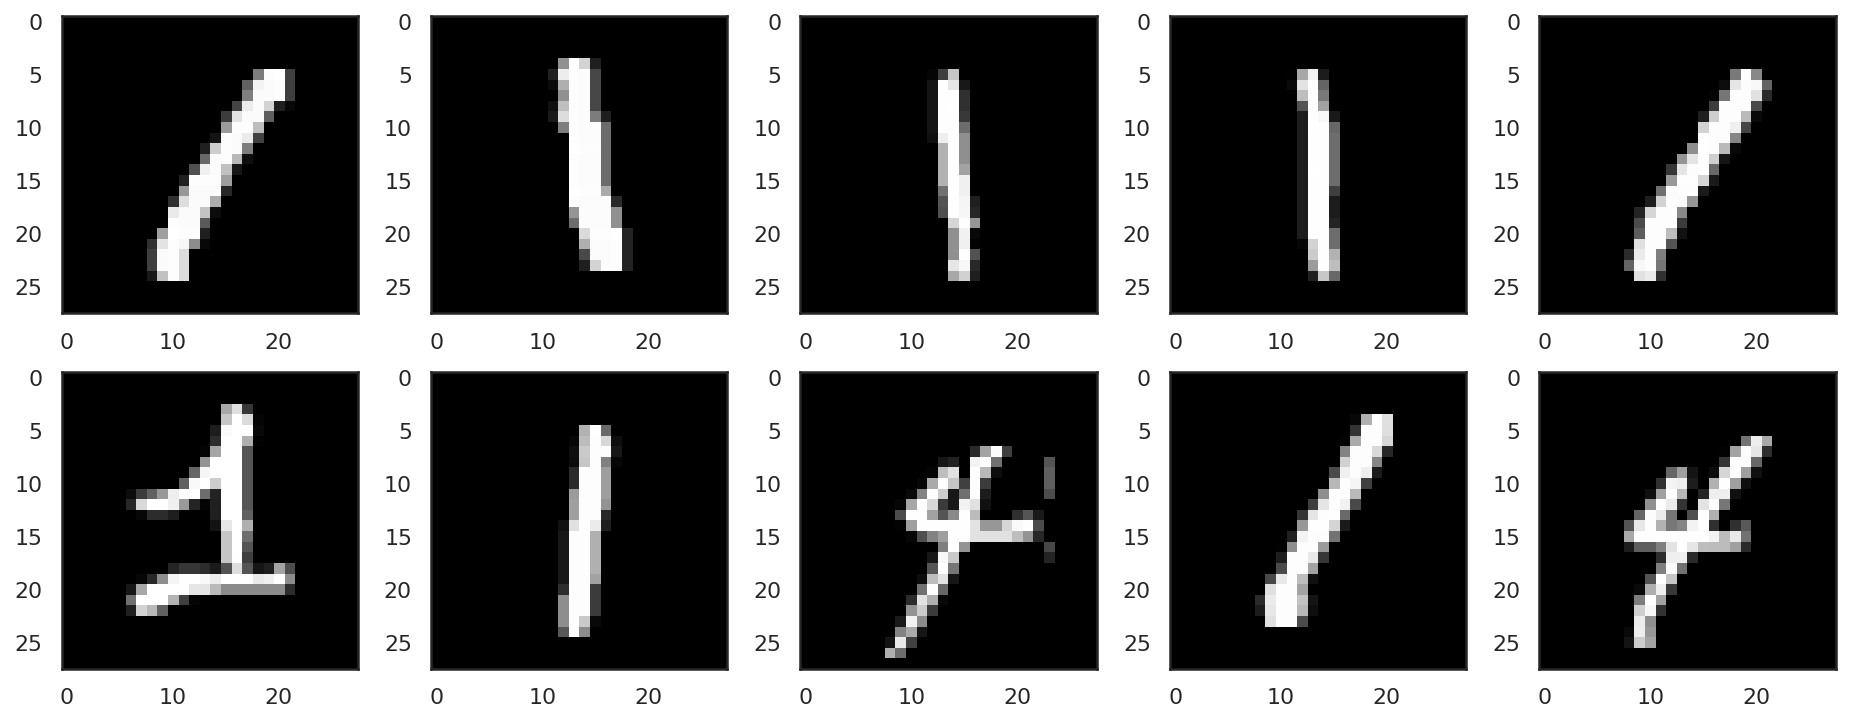

In [ ]:
# Визуализируем
for cluster_number in range(clusters_count):    # берём номер кластера
    print('выводим кластер №', cluster_number)
    plot_pic(X[pred==cluster_number,:])       # получаем данные и выводим картинки каждого класса 
    print()                            

Видим улучшение как метрики, так и визуально кластеризация выглядит лучше, чем на занятии.

##Продвинутый

Загрузите с сайта ООО "Университета Цифровых Технологий платформа 3" базу sale_order_3.csv. Объедините её с sale_order_2.csv и проведите кластеризацию по образцу с занятия, но исключая различные столбцы и группы столбцов данных. Лучше подобрать такое сочетание, которое посчитаете удачным для анализа. Сделайте выводы, в каких случаях может быть применена кластеризация в выбранном сочетании данных.

### Разделение на кластеры базы товаров магазина и анализ

####Загружаем данные


In [ ]:
!rm -R sale_order_2.csv
!rm -R sale_order_3.csv
!wget http://dataudt.ru/datasets/clustering/sale_order_2.csv
!wget http://dataudt.ru/datasets/clustering/sale_order_3.csv

--2021-07-01 10:13:41--  http://dataudt.ru/datasets/clustering/sale_order_2.csv
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1175722 (1.1M) [application/octet-stream]
Saving to: ‘sale_order_2.csv’

sale_order_2.csv    100%[===================>]   1.12M  1.30MB/s    in 0.9s    

2021-07-01 10:13:42 (1.30 MB/s) - ‘sale_order_2.csv’ saved [1175722/1175722]

--2021-07-01 10:13:42--  http://dataudt.ru/datasets/clustering/sale_order_3.csv
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1206910 (1.2M) [application/octet-stream]
Saving to: ‘sale_order_3.csv’

sale_order_3.csv    100%[===================>]   1.15M  1.15MB/s    in 1.0s    

2021-07-01 10:13:44 (1.15 MB/s) - ‘sale_order_3.csv’ saved [1206910/1206910]



In [ ]:
sale_order_2_df_ = pd.read_csv('sale_order_2.csv', delimiter = ';', encoding = 'cp866')  # Читаем данные из загруженной базы
sale_order_3_df = pd.read_csv('sale_order_3.csv', delimiter = ';', encoding = 'cp866')  # Читаем данные из загруженной базы
sale_order_2_df_.head()

,Дата создания,ID,Покупатель,Статус,Оплачен,Отменен,Отгружен,Проблема с заказом,Сумма,Позиции,Отгрузки,Оплаты
0,10.03.2021 23:46:03,№3131,Соколова Евгения,"Принят, ожидается оплата",Нет,Нет,[5381] Нет,Нет,2 142.00 руб.,[1541] Гель для бюста Natural (1.00 шт),"[5381], авиа доставка air (Доставка), 799.00 р...","[3130], Оплата банковским переводом, Не оплаче..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1184] Капсулы для увеличения груди PUERARIA M...,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[704] Лечебно-Профилактические Тампоны Beautif...,NaN,NaN
3,10.03.2021 02:40:22,№3130,Виктория Горбачева,"Оплачен, формируется к отправке",Нет,Нет,[5379] Нет,Нет,1 434.00 руб.,[1443] Гель от шрамов SCAR GEL GIFFARINE (1.00...,"[5379], авиа доставка air (Доставка), 799.00 р...","[3129], Оплата банковским переводом, Не оплаче..."
4,09.03.2021 20:56:57,№3129,Ксения Сахарова,"Принят, ожидается оплата",Нет,Нет,[5377] Нет,Нет,3 742.00 руб.,[372] Женский секрет (шарики для женщин) (2.00...,"[5377], авиа доставка air (Доставка), 1 590.00...","[3128], Оплата банковским переводом, Не оплаче..."


In [ ]:
sale_order_3_df.head()

,Дата создания,ID,Покупатель,Статус,Оплачен,Отменен,Отгружен,Проблема с заказом,Сумма,Позиции,Отгрузки,Оплаты
0,01.01.2018 20:01:28,№1578,Елена Куликова,"Принят, ожидается оплата",Нет,Нет,[2274] Нет,Нет,10 901.80 руб.,[521] JINDA Травяной Набор Шампунь+Кондиционер...,"[2274], наземная отправка Surface (Доставка), ...","[1577], RoboKassa, Не оплачен, 10 901.80 руб."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[780] Шампунь для роста и против выпадения вол...,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[781] Кондиционер для роста и против выпадения...,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1028] Интенсивная сыворотка для роста волос G...,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[779] Тоник для роста и против выпадения волос...,NaN,NaN


In [ ]:
sale_order_3_df.tail()

,Дата создания,ID,Покупатель,Статус,Оплачен,Отменен,Отгружен,Проблема с заказом,Сумма,Позиции,Отгрузки,Оплаты
12384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[125] Нижнее белье Интимный Вечер (1.00 шт),NaN,NaN
12385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[48] Штаны Полосатый Рейс (1.00 шт),NaN,NaN
12386,08.12.2014 15:41:58,№1,Ксения Сахарова,Выполнен,Да,Нет,[1] Нет,Нет,6 897.00 руб.,[67] Штаны Жизнь в Абстракции (1.00 шт),"[1], Без доставки, 0.00 руб., Доставка разреше...","[1], Наложенный платеж, Оплачен, 6 897.00 руб."
12387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[55] Штаны Полосатый Рейс (1.00 шт),NaN,NaN
12388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[223] Туфли Вечерняя Бабочка (1.00 шт),NaN,NaN


In [ ]:
sale_order_2_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Дата создания       1554 non-null   object
 1   ID                  1554 non-null   object
 2   Покупатель          1554 non-null   object
 3   Статус              1554 non-null   object
 4   Оплачен             1554 non-null   object
 5   Отменен             1554 non-null   object
 6   Отгружен            1554 non-null   object
 7   Проблема с заказом  1554 non-null   object
 8   Сумма               1554 non-null   object
 9   Позиции             11094 non-null  object
 10  Отгрузки            1554 non-null   object
 11  Оплаты              1554 non-null   object
dtypes: object(12)
memory usage: 1.0+ MB


In [ ]:
sale_order_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12389 entries, 0 to 12388
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Дата создания       1564 non-null   object
 1   ID                  1564 non-null   object
 2   Покупатель          1564 non-null   object
 3   Статус              1564 non-null   object
 4   Оплачен             1564 non-null   object
 5   Отменен             1564 non-null   object
 6   Отгружен            1563 non-null   object
 7   Проблема с заказом  1564 non-null   object
 8   Сумма               1564 non-null   object
 9   Позиции             12389 non-null  object
 10  Отгрузки            1564 non-null   object
 11  Оплаты              1563 non-null   object
dtypes: object(12)
memory usage: 1.1+ MB


####Подготавливаем данные

In [ ]:
columns = ['Дата создания', 'ID', 'Покупатель', 'Статус', 'Оплачен', 'Отменен', 'Отгружен', 'Проблема с заказом', 'Сумма', 'Позиции', 'Отгрузки', 'Оплаты']
columns_to_fill = ['Дата создания', 'ID', 'Покупатель', 'Статус', 'Оплачен', 'Отменен', 'Отгружен', 'Проблема с заказом', 'Сумма', 'Отгрузки', 'Оплаты']

In [ ]:
sale_order_2_df_fill_ = base_fill(sale_order_2_df_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Дата создания       11094 non-null  object
 1   ID                  11094 non-null  object
 2   Покупатель          11094 non-null  object
 3   Статус              11094 non-null  object
 4   Оплачен             11094 non-null  object
 5   Отменен             11094 non-null  object
 6   Отгружен            11094 non-null  object
 7   Проблема с заказом  11094 non-null  object
 8   Сумма               11094 non-null  object
 9   Позиции             11094 non-null  object
 10  Отгрузки            11094 non-null  object
 11  Оплаты              11094 non-null  object
dtypes: object(12)
memory usage: 1.0+ MB
Датафрейм заполнен.
число заказов: 1554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
sale_order_3_df_fill = base_fill(sale_order_3_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12389 entries, 0 to 12388
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Дата создания       12389 non-null  object
 1   ID                  12389 non-null  object
 2   Покупатель          12389 non-null  object
 3   Статус              12389 non-null  object
 4   Оплачен             12389 non-null  object
 5   Отменен             12389 non-null  object
 6   Отгружен            12389 non-null  object
 7   Проблема с заказом  12389 non-null  object
 8   Сумма               12389 non-null  object
 9   Позиции             12389 non-null  object
 10  Отгрузки            12389 non-null  object
 11  Оплаты              12389 non-null  object
dtypes: object(12)
memory usage: 1.1+ MB
Датафрейм заполнен.
число заказов: 1563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
sale_order_2_df_fill = pd.concat((sale_order_2_df_fill_, sale_order_3_df_fill), axis = 0) #объединяем обе базы

In [ ]:
sale_order_2_df_fill.shape

(23483, 12)

In [ ]:
data_column = 'Дата создания'
sale_order_2_df_fill = get_datetime(sale_order_2_df_fill, data_column)

In [ ]:
id_column = 'ID'
sale_order_2_df_fill = get_id(sale_order_2_df_fill, id_column)

In [ ]:
len(sale_order_2_df_fill['Число ID'].unique())

3116

In [ ]:
len(sale_order_2_df_fill['Отгружен'].unique())

3116

In [ ]:
sale_order_2_df_fill['Отгружен'].unique()

array(['[5381] Нет', '[5379] Нет', '[5377] Нет', ..., '[3] Нет',
       '[2] Нет', '[1] Нет'], dtype=object)

In [ ]:
#парсим идентификатор отгрузки
sale_order_2_df_fill = get_number_data(sale_order_2_df_fill, 'Отгружен', 'ID отгрузки')
len(sale_order_2_df_fill['ID отгрузки'].unique())

3116

In [ ]:
np.sort(sale_order_2_df_fill['ID отгрузки'].unique())

array([   1,    2,    3, ..., 5377, 5379, 5381])

In [ ]:
len(sale_order_2_df_fill['Покупатель'].unique())

1597

In [ ]:
# сопоставим коды покупателям
sale_order_2_df_fill, customer_enc = make_lab_enc(sale_order_2_df_fill, 'Покупатель', 'Код покупателя')

In [ ]:
sale_order_2_df_fill['Статус'].unique()

array(['Принят, ожидается оплата', 'Оплачен, формируется к отправке',
       'Выполнен'], dtype=object)

In [ ]:
# сопоставим коды статусам
sale_order_2_df_fill, status_enc = make_lab_enc(sale_order_2_df_fill, 'Статус', 'Код cтатуса')

In [ ]:
sale_order_2_df_fill['Оплачен'].unique()

array(['Нет', 'Да'], dtype=object)

In [ ]:
# сопоставим коды оплате
sale_order_2_df_fill, status_enc = make_lab_enc(sale_order_2_df_fill, 'Оплачен', 'Оплачен ли')

In [ ]:
sale_order_2_df_fill['Отменен'].unique()

array(['Нет', 'Да'], dtype=object)

In [ ]:
# сопоставим коды отмене
sale_order_2_df_fill, status_enc = make_lab_enc(sale_order_2_df_fill, 'Отменен', 'Отменен ли')

In [ ]:
# парсим результат отгрузки
sale_order_2_df_fill = get_loading_data(sale_order_2_df_fill, 'Отгружен', 'Отгружен ли')
sale_order_2_df_fill['Отгружен ли'].unique()

array([' Нет', 'Нет', 'Нет[896] Нет', 'ет', 'т'], dtype=object)

In [ ]:
#смысла в колонке нет, неинформативна, удаляем.
sale_order_2_df_fill.drop(columns = ['Отгружен ли'], inplace = True)

In [ ]:
sale_order_2_df_fill['Проблема с заказом'].unique()

array(['Нет'], dtype=object)

In [ ]:
#смысла в колонке нет, неинформативна, удаляем.
sale_order_2_df_fill.drop(columns = ['Проблема с заказом'], inplace = True)

In [ ]:
len(sale_order_2_df_fill['Позиции'].unique())

5243

Что можем получить из столбца с приобретённым товаром

In [ ]:
positions = sale_order_2_df_fill['Позиции'].values
positions

array(['[1541] Гель для бюста Natural (1.00 шт)',
       '[1184] Капсулы для увеличения груди PUERARIA MIRIFICA (1.00 шт)',
       '[704] Лечебно-Профилактические Тампоны Beautiful Life (1.00 шт)',
       ..., '[67] Штаны Жизнь в Абстракции (1.00 шт)',
       '[55] Штаны Полосатый Рейс (1.00 шт)',
       '[223] Туфли Вечерняя Бабочка (1.00 шт)'], dtype=object)

In [ ]:
len(positions)

23483

In [ ]:
# парсим номера номенклатуры товаров, проверяем их уникальность
sale_order_2_df_fill = get_number_data(sale_order_2_df_fill, 'Позиции', '№ позиции')
len(sale_order_2_df_fill['№ позиции'].unique()) 

2266

In [ ]:
np.sort(sale_order_2_df_fill['№ позиции'].unique())

array([  45,   48,   55, ..., 3128, 3129, 3130])

In [ ]:
sale_order_2_df_fill['№ позиции'].min()

45

In [ ]:
sale_order_2_df_fill['№ позиции'].max()

3130

In [ ]:
#итого: можно перекодировать уникальные номера, чтобы сделать вектор короче, но необязательно

In [ ]:
#узнаём минимальное количество символов в позиции
min_len = 1000
for position in positions:
    l = len(position)
    if l < min_len:
        min_len = l
print(min_len)

22


In [ ]:
#парсим количество заказанного
sale_order_2_df_fill = get_quantity_data(sale_order_2_df_fill, 'Позиции', 'Количество')
print(np.sort(sale_order_2_df_fill['Количество'].unique()))

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   24   25   27   28   30
   31   32   34   35   40   50   55   60   91   92   98  100  200  250
  500 3000]


In [ ]:
# для просмотра оплаты воспользуемся парсингом текста почти как для отгрузки:
sale_order_2_df_fill = get_payment_data(sale_order_2_df_fill, 'Оплаты', 'Тип оплаты')
len(sale_order_2_df_fill['Тип оплаты'].unique())

31

In [ ]:
sale_order_2_df_fill['Тип оплаты'].unique()

array(['Оплата банковским переводом, Не оплачен',
       'Оплата банковским переводом, Не оплачен,',
       'Оплата банковским переводом, Не оплач', 'RoboKassa, Не оплач',
       'RoboKassa, Не оплачен', 'RoboKassa, Оплачен, Статус: Y',
       'RoboKassa, Не оплачен,', 'RoboKassa, Оплачен, Статус:',
       'RoboKassa, Оплачен, Статус: Y,', 'Внутренний счёт, Не оплачен',
       'oboKassa, Не оплачен', 'плата банковским переводом, Не оплачен',
       'плата банковским переводом, Не оплач', 'oboKassa, Не оплач',
       'oboKassa, Не оплачен,', 'oboKassa, Оплачен, Статус: Y',
       'плата банковским переводом, Не оплачен,',
       'oboKassa, Не оплачен, ', 'oboKassa, Оплачен, Статус:',
       'oboKassa, Оплачен, Статус: Y,',
       'плата банковским переводом, Оплачен', 'oboKassa, Оплачен, Стату',
       'лата банковским переводом, Не оплачен',
       'лата банковским переводом, Не оплачен,',
       'лата банковским переводом, Не оплач',
       'ата банковским переводом, Не оплачен',
    

In [ ]:
# имеет смысл закодировать колонку по признакам:
sale_order_2_df_fill['Тип оплаты'][sale_order_2_df_fill['Тип оплаты'].str.contains('банк')] = '0'
sale_order_2_df_fill['Тип оплаты'][sale_order_2_df_fill['Тип оплаты'].str.contains('Kassa')] = '1'
sale_order_2_df_fill['Тип оплаты'][sale_order_2_df_fill['Тип оплаты'].str.contains('женн')] = '2'
sale_order_2_df_fill['Тип оплаты'][sale_order_2_df_fill['Тип оплаты'].str.contains('I, Не опл')] = '3'
sale_order_2_df_fill['Тип оплаты'][sale_order_2_df_fill['Тип оплаты'].str.contains('Внутр')] = '4'
sale_order_2_df_fill['Тип оплаты'] = sale_order_2_df_fill['Тип оплаты'].values.astype('int32')
sale_order_2_df_fill['Тип оплаты'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

array([0, 1, 4, 3, 2], dtype=int32)

In [ ]:
# для просмотра доставки воспользуемся парсингом текста почти как для оплаты:
sale_order_2_df_fill = get_payment_data(sale_order_2_df_fill, 'Отгрузки', 'Тип отгрузки')
len(sale_order_2_df_fill['Тип отгрузки'].unique())

1270

In [ ]:
sale_order_2_df_fill['Тип отгрузки'].unique()

array(['авиа доставка air (Доставка), 799.00 руб., Доставка не разрешена, Ожидает',
       'авиа доставка air (Доставка), 1 590.00 руб., Доставка не разрешена, Ожидает',
       'авиа доставка air (Доставка), 799.00 руб., Доставка не разрешена, RR341906013TH, Ожидает',
       ...,
       ' доставки, 0.00 руб., Доставка не разрешена, Отгрузка отменена, Ожидает',
       ' доставки, 0.00 руб., Доставка не разрешена, Ожидает',
       ' доставки, 0.00 руб., Доставка разрешена, Ожидает'], dtype=object)

очевидно, ключевые слова будут наземная, авиа, уточните, и 4 вариант

In [ ]:
sale_order_2_df_fill['Код отгрузки'] = sale_order_2_df_fill['Тип отгрузки']
sale_order_2_df_fill['Код отгрузки'][sale_order_2_df_fill['Код отгрузки'].str.contains('авиа')] = '0'
sale_order_2_df_fill['Код отгрузки'][sale_order_2_df_fill['Код отгрузки'].str.contains('земная')] = '1'
sale_order_2_df_fill['Код отгрузки'][sale_order_2_df_fill['Код отгрузки'].str.contains('точн')] = '2'
sale_order_2_df_fill['Код отгрузки'][sale_order_2_df_fill['Код отгрузки'].str.contains('ставка')] = '3'
sale_order_2_df_fill['Код отгрузки'][sale_order_2_df_fill['Код отгрузки'].str.contains('ставки')] = '4'
sale_order_2_df_fill['Код отгрузки'] = sale_order_2_df_fill['Код отгрузки'].values.astype('int32')
sale_order_2_df_fill['Код отгрузки'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

array([0, 1, 2, 3], dtype=int32)

In [ ]:
sale_order_2_df_fill[0:1]['Сумма']

0    2 142.00 руб.
Name: Сумма, dtype: object

In [ ]:
# парсим сумму оплаты товара
sale_order_2_df_fill['Сумма, руб.'] = sale_order_2_df_fill['Сумма'].apply(lambda x: np.array(re.findall('\d+', x.replace(' ',''))[0]).astype('int32'))

In [ ]:
# парсим сумму оплаты доставки
sale_order_2_df_fill['Доставка, руб.'] = sale_order_2_df_fill['Тип отгрузки'].apply(lambda x: np.array(re.findall('\d+', x.replace(' ',''))[0]).astype('int32'))
#смысла в колонке нет, далее не нужна, удаляем.
sale_order_2_df_fill.drop(columns = ['Тип отгрузки'], inplace = True)

####Работаем с подготовленными данными
Убеждаемся, что всё проделали правильно

In [ ]:
sale_order_2_df_fill.head()

,Дата создания,ID,Покупатель,Статус,Оплачен,Отменен,Отгружен,Сумма,Позиции,Отгрузки,Оплаты,Год,Mесяц,День,День недели,Час,Число ID,ID отгрузки,Код покупателя,Код cтатуса,Оплачен ли,Отменен ли,№ позиции,Количество,Тип оплаты,Код отгрузки,"Сумма, руб.","Доставка, руб."
0,2021-10-03 23:46:03,№3131,Соколова Евгения,"Принят, ожидается оплата",Нет,Нет,[5381] Нет,2 142.00 руб.,[1541] Гель для бюста Natural (1.00 шт),"[5381], авиа доставка air (Доставка), 799.00 р...","[3130], Оплата банковским переводом, Не оплаче...",2021,10,3,6,23,3131,5381,1307,2,1,1,1541,1,0,0,2142,799
1,2021-10-03 23:46:03,№3131,Соколова Евгения,"Принят, ожидается оплата",Нет,Нет,[5381] Нет,2 142.00 руб.,[1184] Капсулы для увеличения груди PUERARIA M...,"[5381], авиа доставка air (Доставка), 799.00 р...","[3130], Оплата банковским переводом, Не оплаче...",2021,10,3,6,23,3131,5381,1307,2,1,1,1184,1,0,0,2142,799
2,2021-10-03 23:46:03,№3131,Соколова Евгения,"Принят, ожидается оплата",Нет,Нет,[5381] Нет,2 142.00 руб.,[704] Лечебно-Профилактические Тампоны Beautif...,"[5381], авиа доставка air (Доставка), 799.00 р...","[3130], Оплата банковским переводом, Не оплаче...",2021,10,3,6,23,3131,5381,1307,2,1,1,704,1,0,0,2142,799
3,2021-10-03 02:40:22,№3130,Виктория Горбачева,"Оплачен, формируется к отправке",Нет,Нет,[5379] Нет,1 434.00 руб.,[1443] Гель от шрамов SCAR GEL GIFFARINE (1.00...,"[5379], авиа доставка air (Доставка), 799.00 р...","[3129], Оплата банковским переводом, Не оплаче...",2021,10,3,6,2,3130,5379,337,1,1,1,1443,1,0,0,1434,799
4,2021-09-03 20:56:57,№3129,Ксения Сахарова,"Принят, ожидается оплата",Нет,Нет,[5377] Нет,3 742.00 руб.,[372] Женский секрет (шарики для женщин) (2.00...,"[5377], авиа доставка air (Доставка), 1 590.00...","[3128], Оплата банковским переводом, Не оплаче...",2021,9,3,4,20,3129,5377,752,2,1,1,372,2,0,0,3742,1590


In [ ]:
sale_order_2_df_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23483 entries, 0 to 12388
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Дата создания   23483 non-null  datetime64[ns]
 1   ID              23483 non-null  object        
 2   Покупатель      23483 non-null  object        
 3   Статус          23483 non-null  object        
 4   Оплачен         23483 non-null  object        
 5   Отменен         23483 non-null  object        
 6   Отгружен        23483 non-null  object        
 7   Сумма           23483 non-null  object        
 8   Позиции         23483 non-null  object        
 9   Отгрузки        23483 non-null  object        
 10  Оплаты          23483 non-null  object        
 11  Год             23483 non-null  int64         
 12  Mесяц           23483 non-null  int64         
 13  День            23483 non-null  int64         
 14  День недели     23483 non-null  int64         
 15  Ча

In [ ]:
cluster_data = sale_order_2_df_fill.iloc[:, 11:].values
cluster_data.shape

(23483, 17)

####Нормализуем данные

In [ ]:
common_scaler = StandardScaler()                       # Создаем объект StandardScaler для стандартного распределения
cluster_data_scaled = common_scaler.fit_transform(cluster_data) # Создаем обучающий набор данных cluster_data_scaled со стандартным распределением на основе cluster_data

In [ ]:
# покажем строку преобразованных данных
n = 0                    # Номер записи 
print(cluster_data_scaled[n]) # Отобразим данные

[ 2.63610673  0.9696333  -1.37165626  1.49572624  1.24321633  1.84853163
  1.95093724  1.26801222  0.85505562  0.31289102  0.24099535  0.34983092
 -0.0603188  -1.04148531 -1.34038108 -0.55652865 -0.49893763]


#### Проводим разбиение на кластеры по различным признакам

In [ ]:
columns = sale_order_2_df_fill.columns.tolist()[11:]
columns

['Год',
 'Mесяц',
 'День',
 'День недели',
 'Час',
 'Число ID',
 'ID отгрузки',
 'Код покупателя',
 'Код cтатуса',
 'Оплачен ли',
 'Отменен ли',
 '№ позиции',
 'Количество',
 'Тип оплаты',
 'Код отгрузки',
 'Сумма, руб.',
 'Доставка, руб.']

Размер кластера: 23483
в кластер попали:
#########################################

статистические данные по столбцам:
-----------------------------------------
Год	: диапазон	2014	-	2021	среднее значение:	2017.3892177319763	разброс:	1.369740542994284


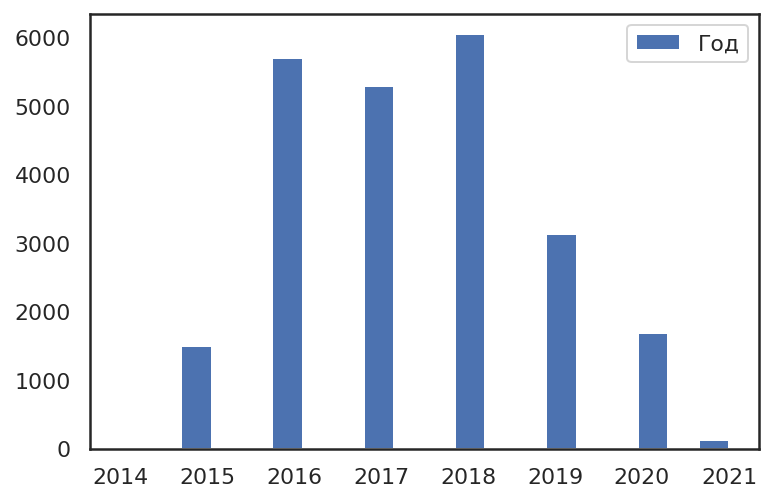


Mесяц	: диапазон	1	-	12	среднее значение:	6.561044159604821	разброс:	3.5466560953436748


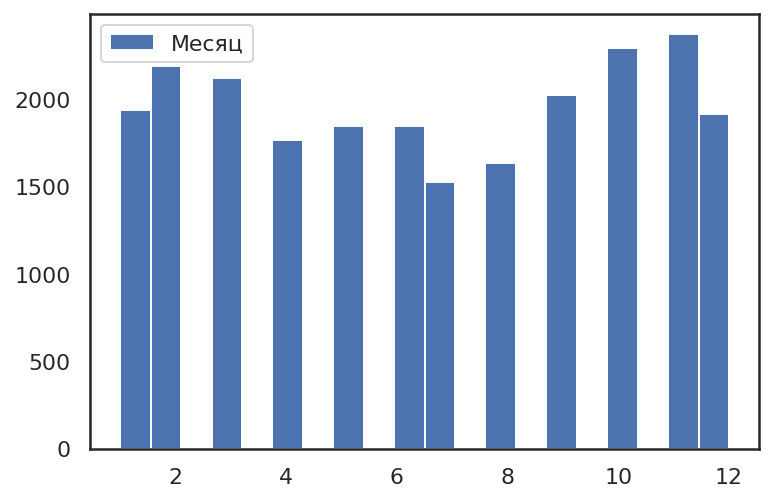


День	: диапазон	1	-	31	среднее значение:	15.0481625005323	разброс:	8.783660177988562


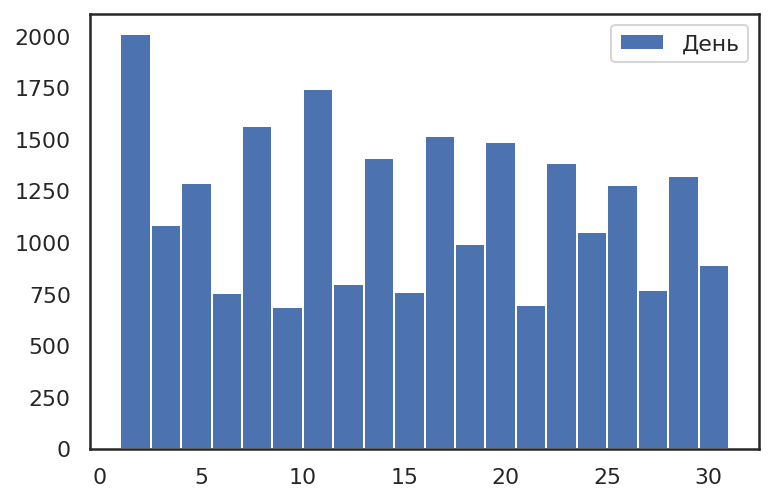


День недели	: диапазон	0	-	6	среднее значение:	2.9423838521483625	разброс:	2.044235138722334


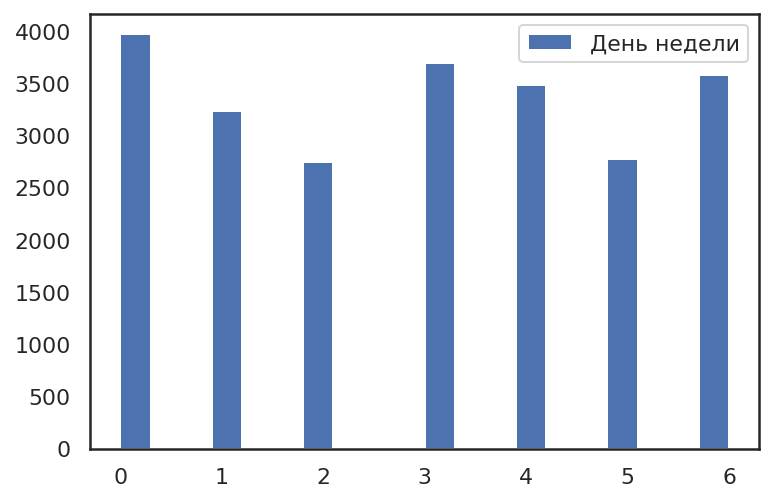


Час	: диапазон	0	-	23	среднее значение:	14.004811991653536	разброс:	7.23541652121317


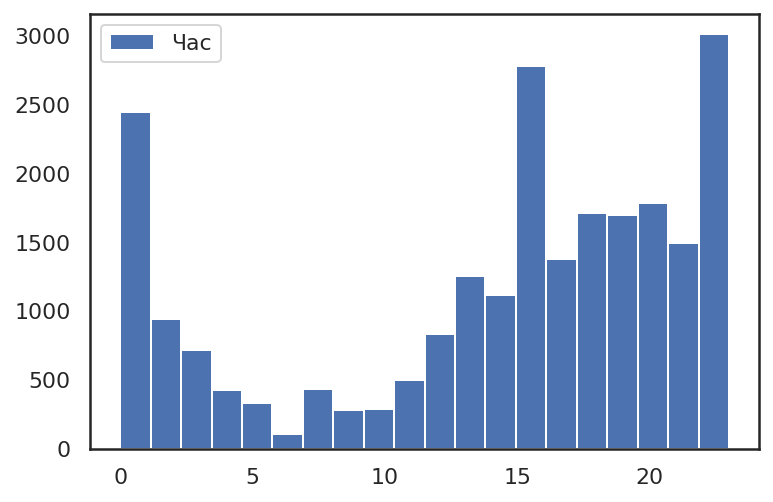


Число ID	: диапазон	1	-	3131	среднее значение:	1522.9385087084274	разброс:	869.9128882915792


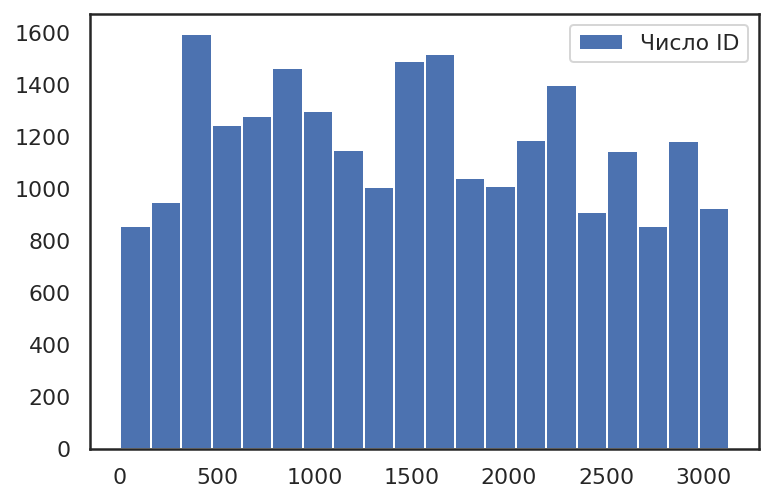


ID отгрузки	: диапазон	1	-	5381	среднее значение:	2280.01750202274	разброс:	1589.4834750066436


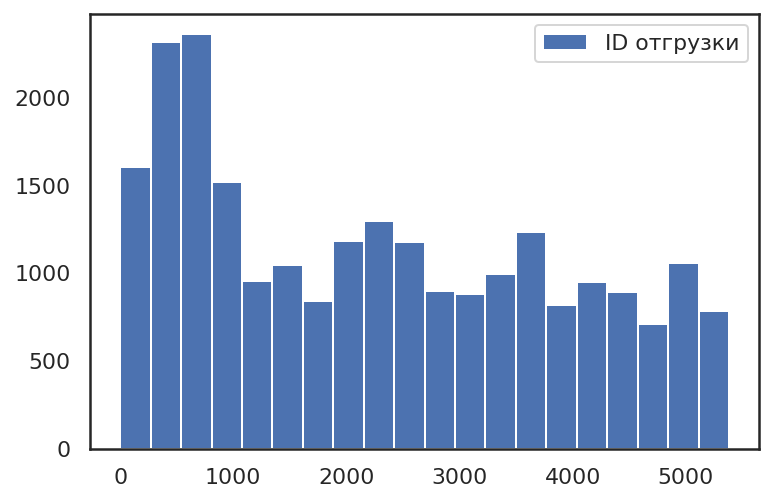


Код покупателя	: диапазон	0	-	1596	среднее значение:	811.896180215475	разброс:	390.45666279704636


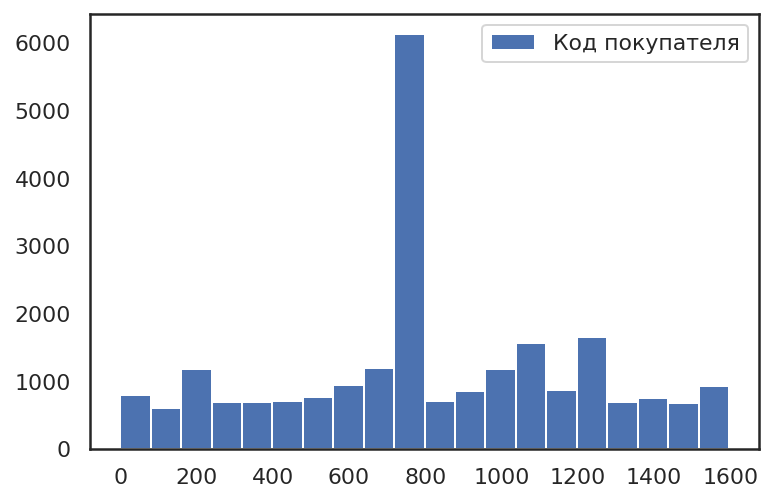


Код cтатуса	: диапазон	0	-	2	среднее значение:	1.227313375633437	разброс:	0.9036682614441086


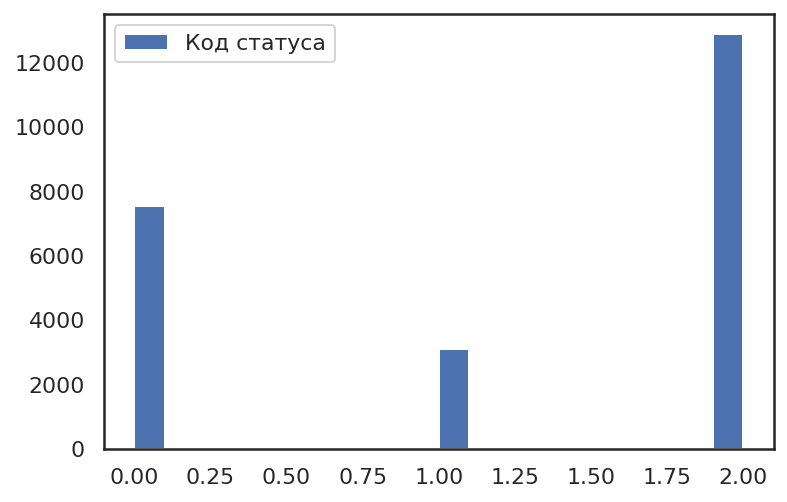


Оплачен ли	: диапазон	0	-	1	среднее значение:	0.910829110420304	разброс:	0.28499024901084186


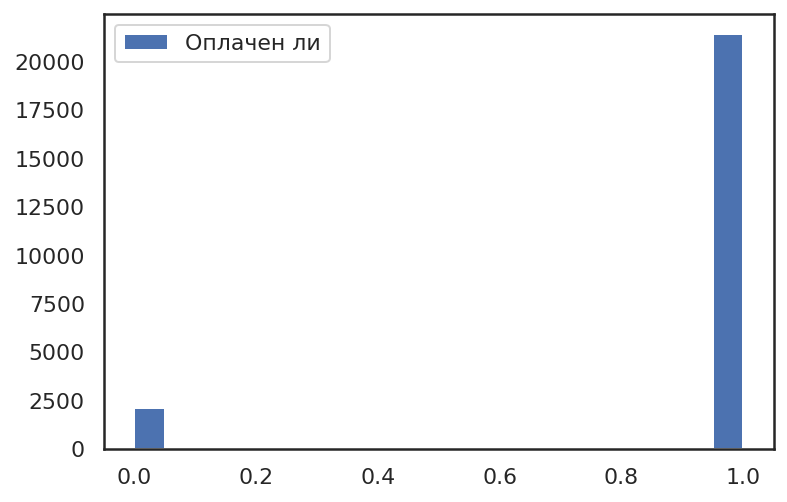


Отменен ли	: диапазон	0	-	1	среднее значение:	0.9451092279521356	разброс:	0.22776693173473142


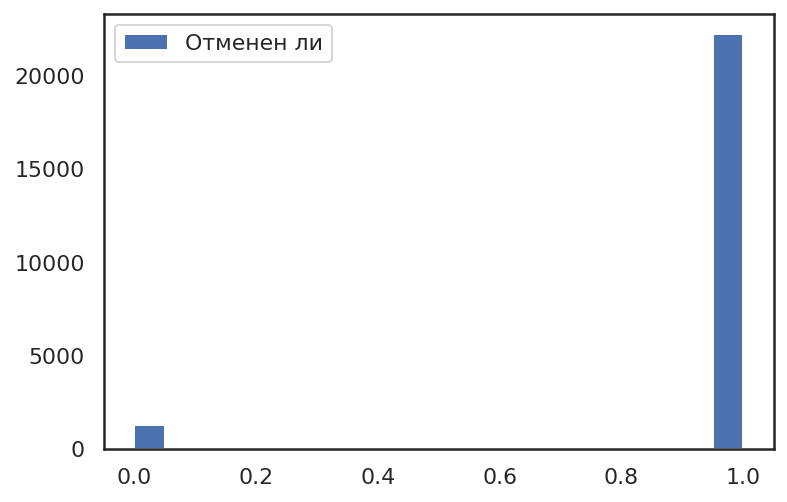


№ позиции	: диапазон	45	-	3130	среднее значение:	1286.8161223012391	разброс:	726.5906487653358


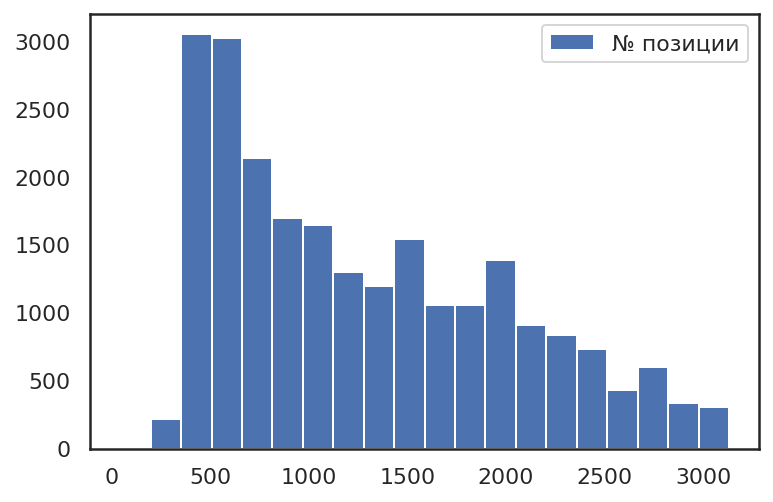


Количество	: диапазон	0	-	3000	среднее значение:	2.2492441340544223	разброс:	20.710692100507107


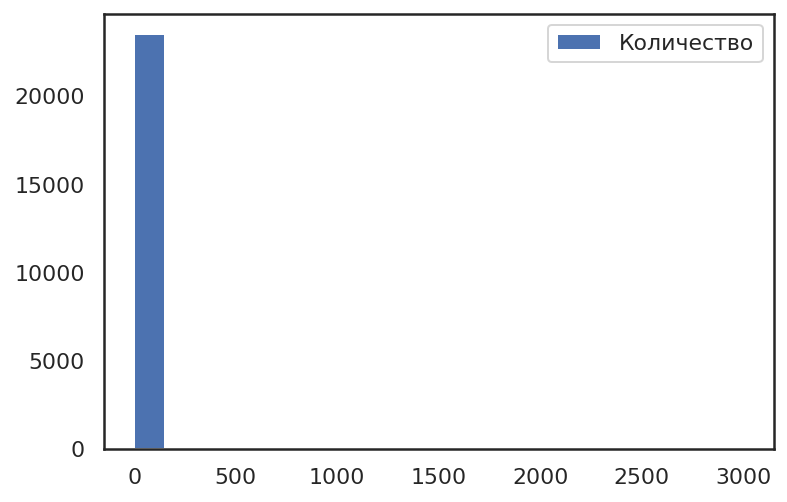


Тип оплаты	: диапазон	0	-	4	среднее значение:	0.5405612570795895	разброс:	0.5190291696133232


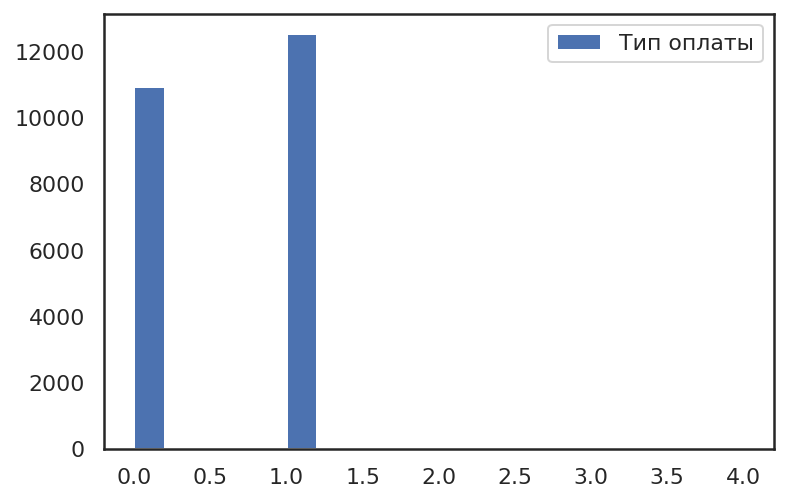


Код отгрузки	: диапазон	0	-	3	среднее значение:	1.4303964570114551	разброс:	1.0671565519919572


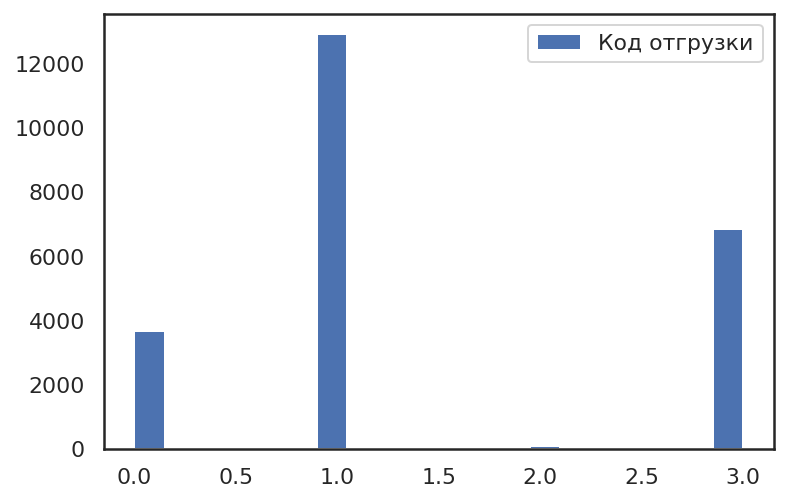


Сумма, руб.	: диапазон	1	-	149227	среднее значение:	11961.276710812077	разброс:	17643.7937588015


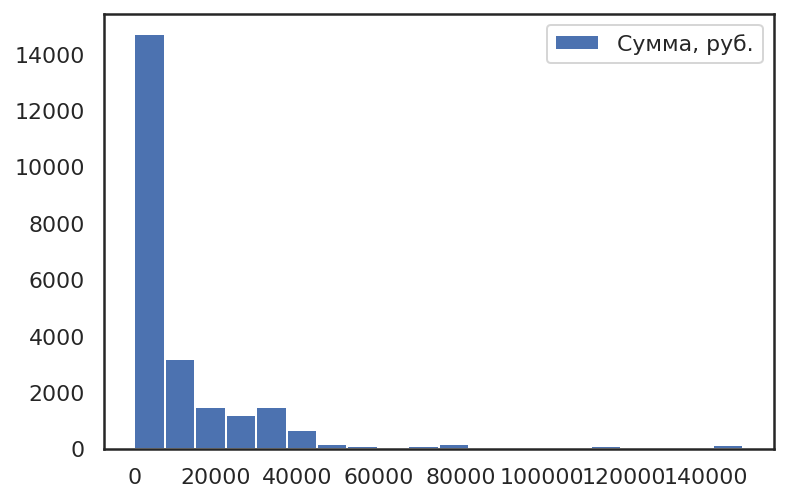


Доставка, руб.	: диапазон	0	-	17813	среднее значение:	2335.9672529063578	разброс:	3080.479716244919


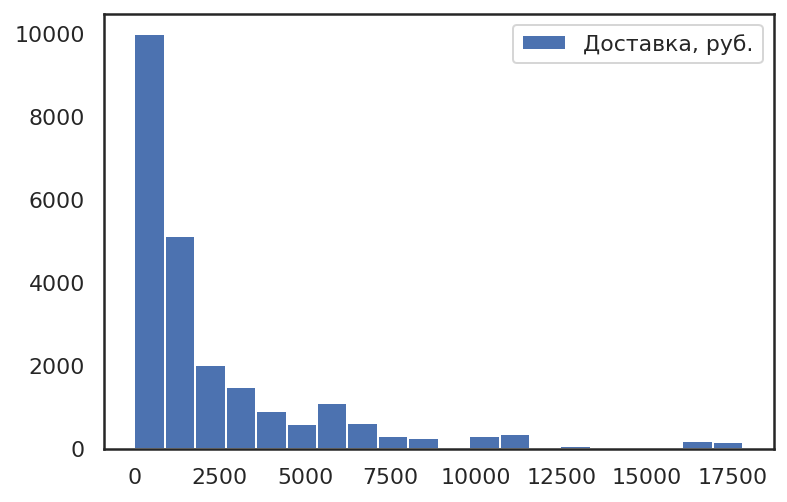

In [ ]:
stats(cluster_data)  # Выведем информацию о cluster_data

Разбиение на 10 кластеров готово
Разбиение на 20 кластеров готово
Разбиение на 30 кластеров готово
Разбиение на 40 кластеров готово
Разбиение на 50 кластеров готово
Разбиение на 60 кластеров готово
Разбиение на 70 кластеров готово
Разбиение на 80 кластеров готово
Разбиение на 90 кластеров готово
Разбиение на 100 кластеров готово
Разбиение на 110 кластеров готово
Разбиение на 120 кластеров готово
Разбиение на 130 кластеров готово
Разбиение на 140 кластеров готово
Разбиение на 150 кластеров готово
Разбиение на 160 кластеров готово
Разбиение на 170 кластеров готово
Разбиение на 180 кластеров готово
Разбиение на 190 кластеров готово
Время обработки:  391.05 c


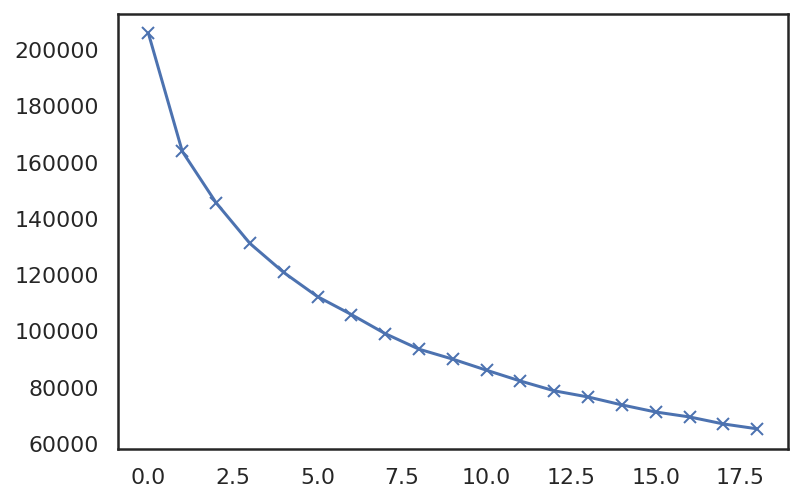

In [ ]:
cur_time = time.time()
# Отобразим график разбияния на различное количество классов
cost = []
for i in range(1,20):
  print("Разбиение на ", i*10, " кластеров готово", sep="")
  kmean = KMeans(i*10)
  kmean.fit(cluster_data_scaled)
  cost.append(kmean.inertia_)
    
plt.plot(cost, 'bx-')
print('Время обработки: ', round(time.time()-cur_time,2),'c');

Итого: использовать 2, 5, 12, 15 кластеров кажется перспективным

In [ ]:
clusters_count = 5            # Задаем количество кластеров
kmean = KMeans(clusters_count) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(cluster_data_scaled)     # Произвдим кластеризацию данных xTrain01Scaled
labels = kmean.labels_        # Получаем метки кластеров

In [ ]:
print(labels[:300])            # Выводим первые 20 меток

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


Размер кластера: 2096
в кластер попали:
#########################################

статистические данные по столбцам:
-----------------------------------------
Год	: диапазон	2014	-	2019	среднее значение:	2017.1669847328244	разброс:	1.1700695124175409


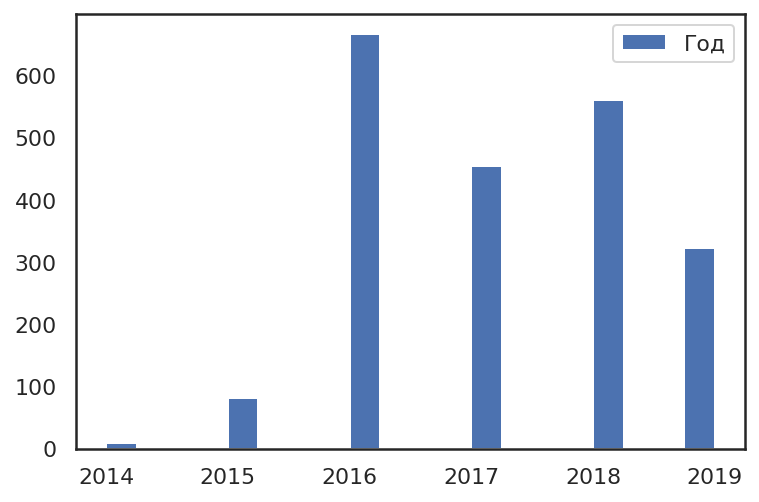


Mесяц	: диапазон	1	-	12	среднее значение:	6.2333015267175576	разброс:	3.469394234132206


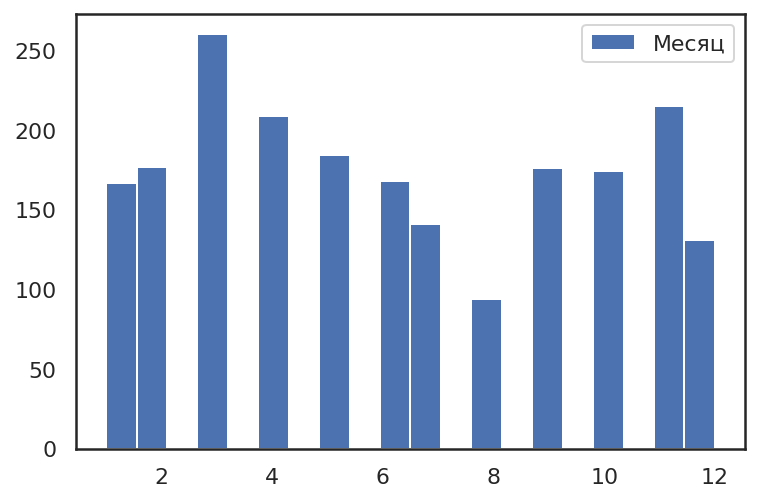


День	: диапазон	1	-	31	среднее значение:	14.034351145038167	разброс:	9.182769052946384


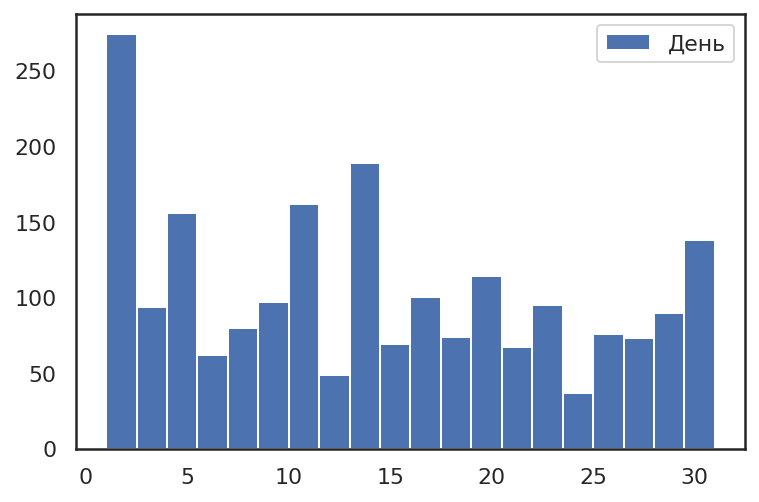


День недели	: диапазон	0	-	6	среднее значение:	3.18368320610687	разброс:	1.9466013107465985


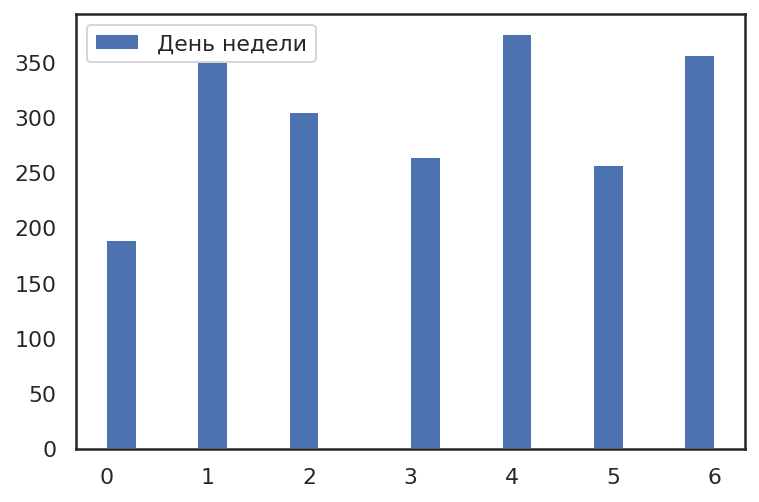


Час	: диапазон	0	-	23	среднее значение:	12.59732824427481	разброс:	7.544022994268862


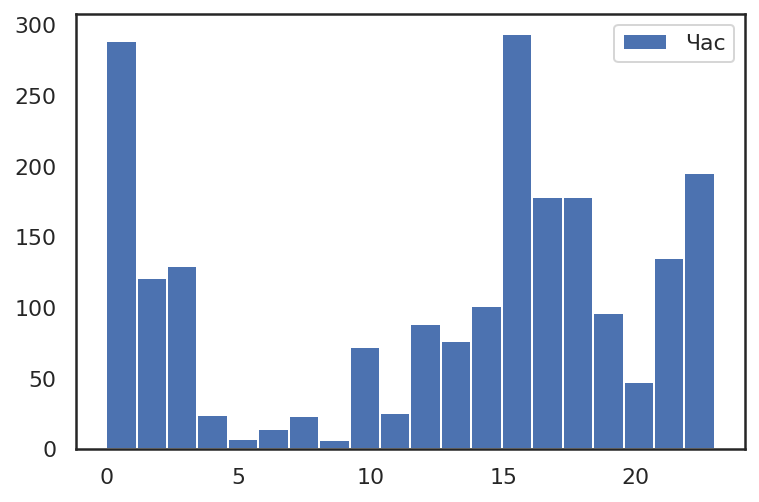


Число ID	: диапазон	1	-	2856	среднее значение:	1354.7294847328244	разброс:	789.3369305271399


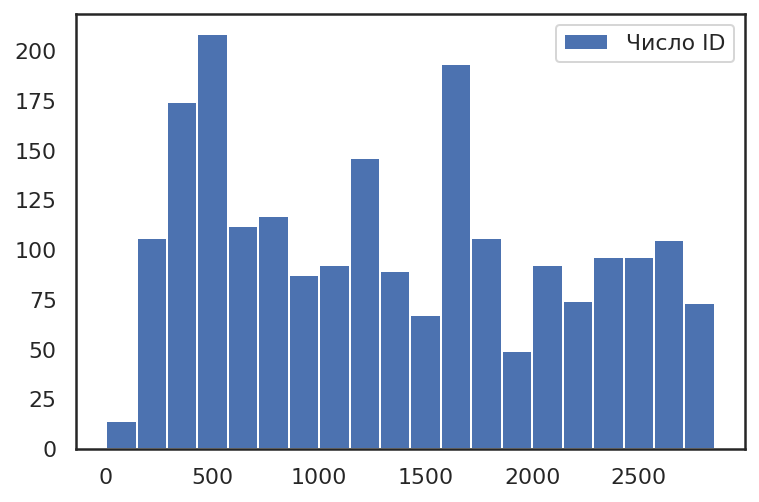


ID отгрузки	: диапазон	1	-	4831	среднее значение:	1962.2266221374045	разброс:	1422.0158574814327


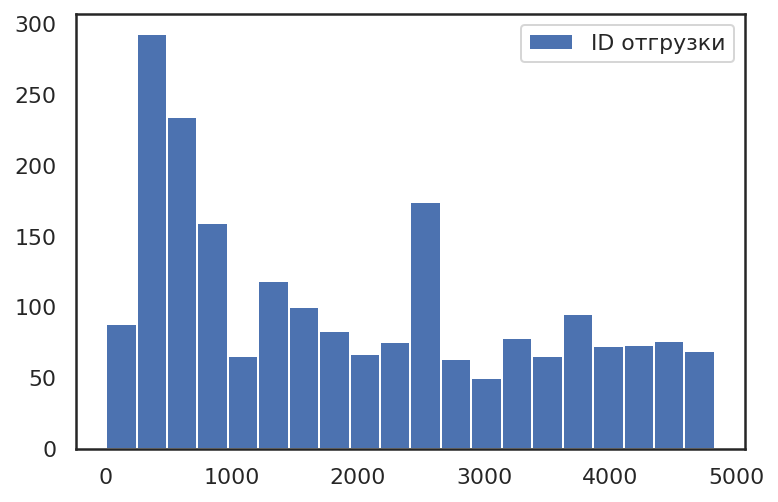


Код покупателя	: диапазон	7	-	1593	среднее значение:	802.3673664122138	разброс:	445.21689709821896


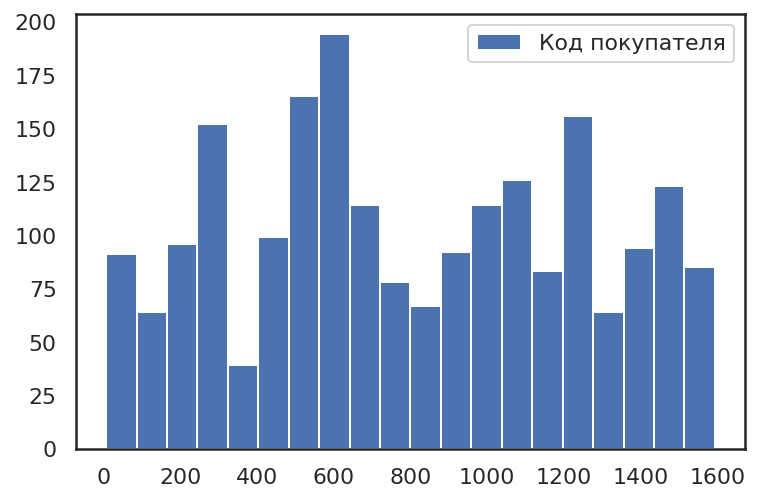


Код cтатуса	: диапазон	0	-	2	среднее значение:	0.24952290076335878	разброс:	0.6015642470831282


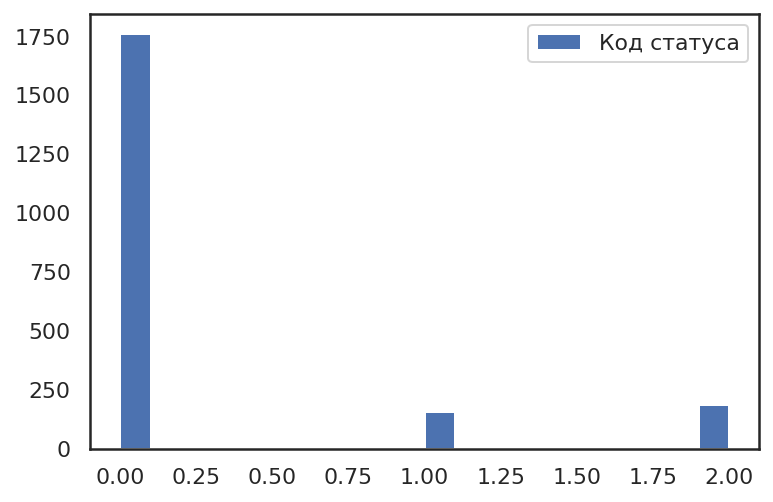


Оплачен ли	: диапазон	0	-	1	среднее значение:	0.0009541984732824427	разброс:	0.030875361998785864


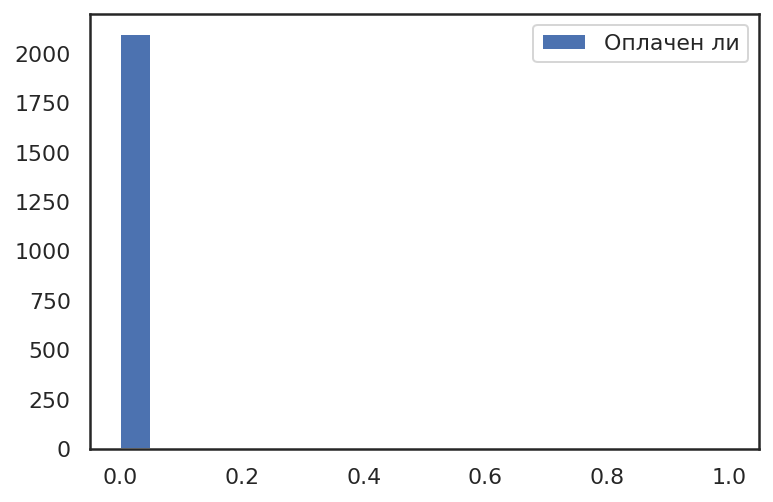


Отменен ли	: диапазон	1	-	1	среднее значение:	1.0	разброс:	0.0


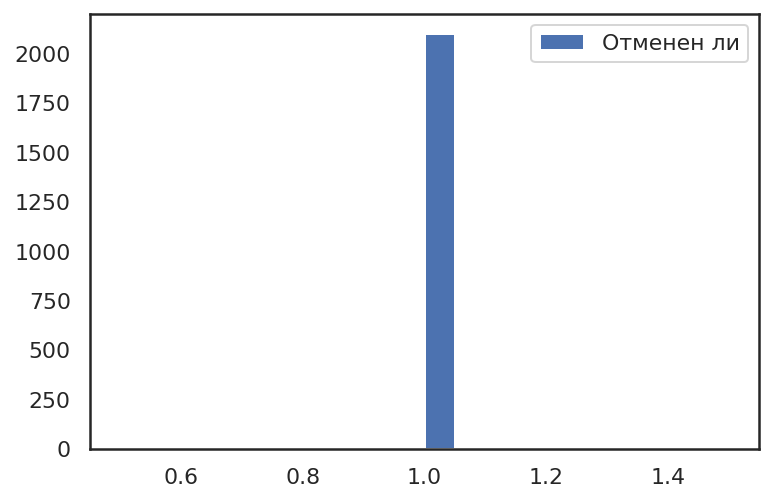


№ позиции	: диапазон	48	-	3075	среднее значение:	1243.5896946564885	разброс:	702.9191297891747


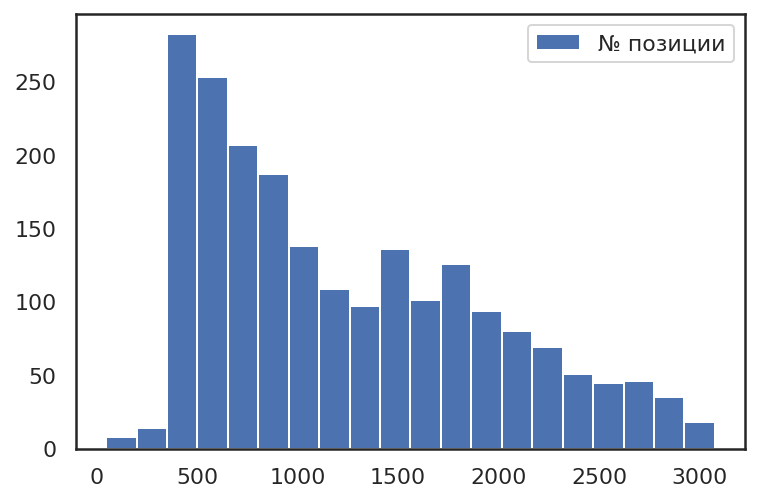


Количество	: диапазон	0	-	3000	среднее значение:	3.170324427480916	разброс:	65.58510944713093


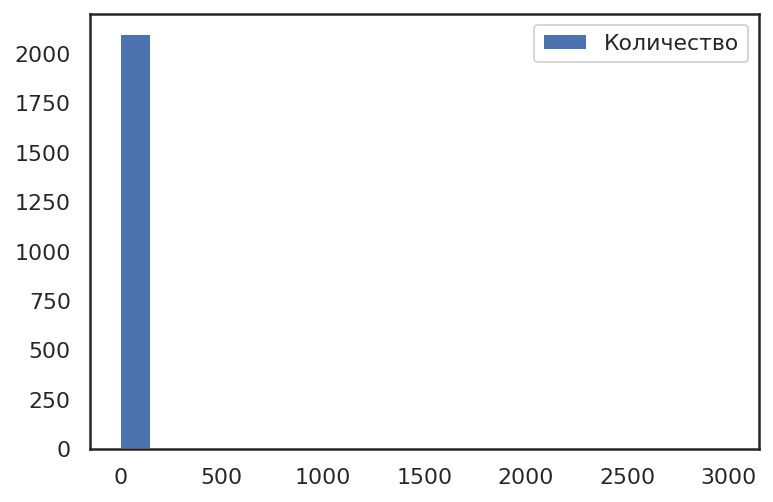


Тип оплаты	: диапазон	0	-	4	среднее значение:	1.004293893129771	разброс:	0.1254027004930549


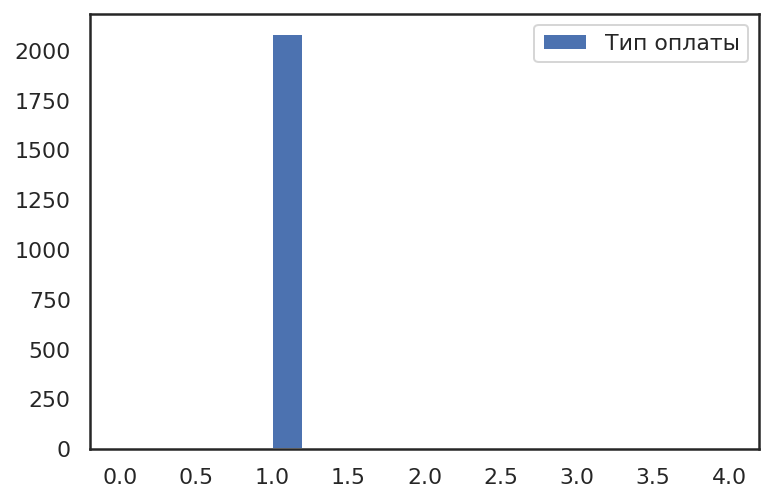


Код отгрузки	: диапазон	0	-	3	среднее значение:	1.6416984732824427	разброс:	1.0534194487647428


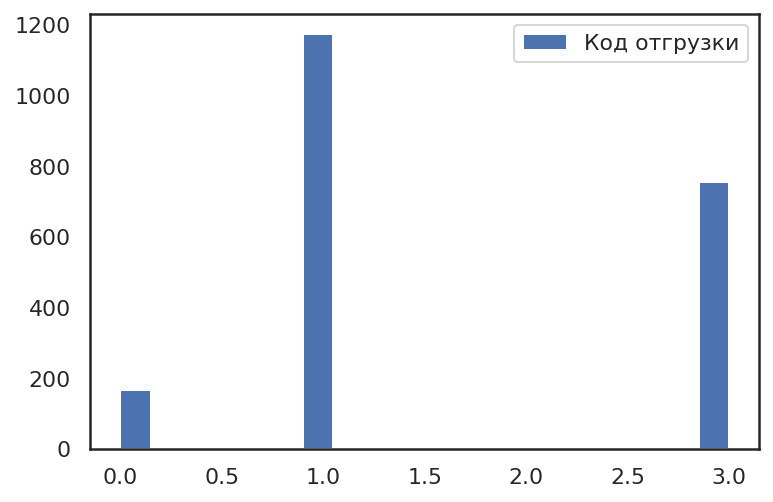


Сумма, руб.	: диапазон	2	-	24745	среднее значение:	4360.634064885497	разброс:	3750.3310299393365


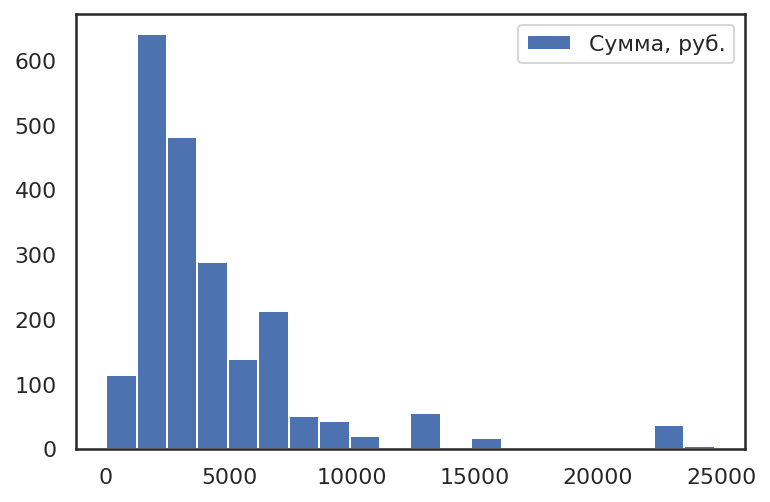


Доставка, руб.	: диапазон	0	-	6036	среднее значение:	1082.2929389312976	разброс:	924.637665813871


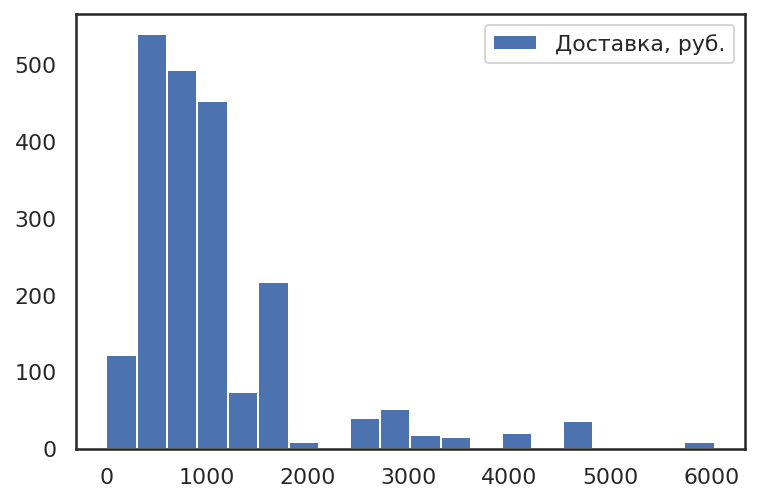

In [ ]:
cluster_number = 0                              # Укажем номер кластера
stats(cluster_data[labels==cluster_number,:]) # Выведем информацию о кластере с указанным номером

Подсказка - смотрим на графики и среднее значение, убираем те столбцы, в которых статистика практически не отличима от оригинального распределения, они только мешают. 

Прежде всего, это данные времени, 'Год', 'Mесяц', 'День', 'День недели', 'Час', '№ позиции', 'Отменен ли'

Оставляем:  'Код покупателя', 'Сумма, руб.', 'Доставка, руб.', 'Тип оплаты', 'Количество', 'Код cтатуса', 'Оплачен ли'

Под вопросом:  'Число ID', 'ID отгрузки', 'Код отгрузки'

С оставленными столбцами потом можно найти интересную Вам статистику, комбинируя их.



In [ ]:
columns = ['Код покупателя', 'Сумма, руб.', 'Доставка, руб.', 'Тип оплаты', 'Количество', 'Код cтатуса', 'Оплачен ли']
cluster_data_ = sale_order_2_df_fill[columns].values
cluster_data_.shape

(23483, 7)

####Нормализуем данные

In [ ]:
common_scaler_ = StandardScaler()                       # Создаем объект StandardScaler для стандартного распределения
cluster_data_scaled_ = common_scaler_.fit_transform(cluster_data_) # Создаем обучающий набор данных cluster_data_scaled со стандартным распределением на основе cluster_data

In [ ]:
# покажем строку преобразованных данных
n = 0                    # Номер записи 
print(cluster_data_scaled_[n]) # Отобразим данные

[ 1.26801222 -0.55652865 -0.49893763 -1.04148531 -0.0603188   0.85505562
  0.31289102]


#### Проводим разбиение на кластеры по различным признакам

Размер кластера: 23483
в кластер попали:
#########################################

статистические данные по столбцам:
-----------------------------------------
Код покупателя	: диапазон	0	-	1596	среднее значение:	811.896180215475	разброс:	390.45666279704636


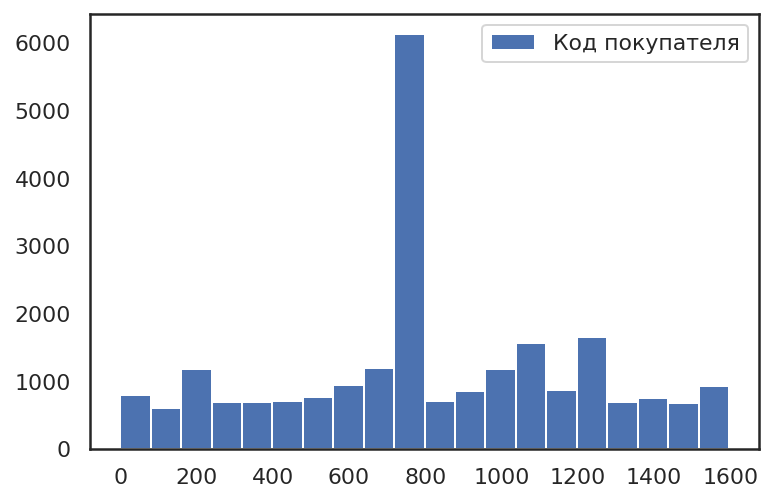


Сумма, руб.	: диапазон	1	-	149227	среднее значение:	11961.276710812077	разброс:	17643.7937588015


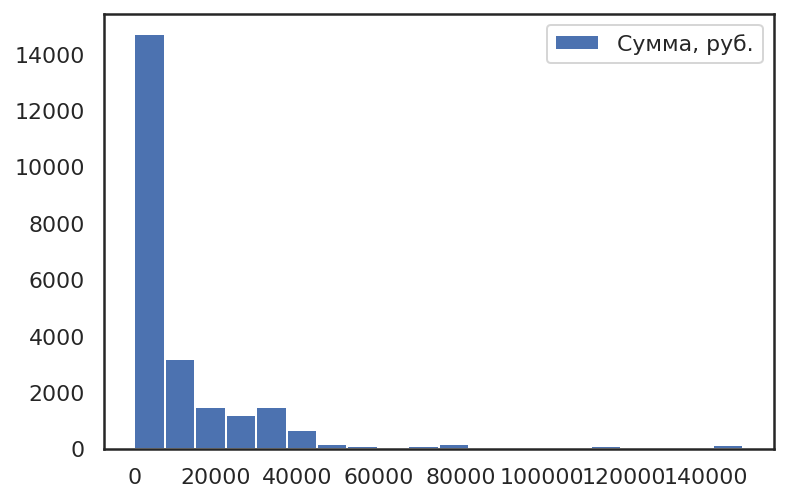


Доставка, руб.	: диапазон	0	-	17813	среднее значение:	2335.9672529063578	разброс:	3080.479716244919


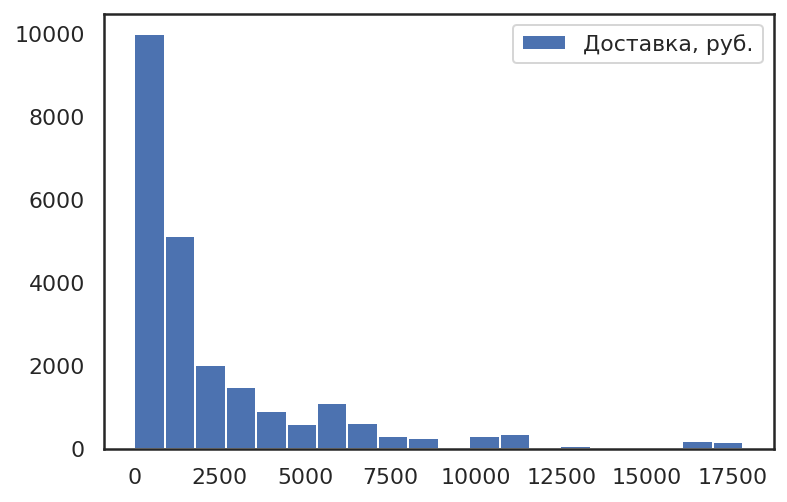


Тип оплаты	: диапазон	0	-	4	среднее значение:	0.5405612570795895	разброс:	0.5190291696133232


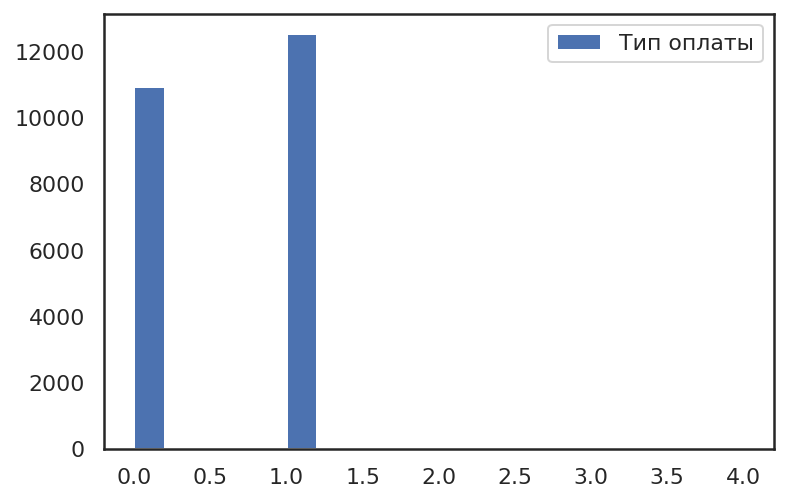


Количество	: диапазон	0	-	3000	среднее значение:	2.2492441340544223	разброс:	20.710692100507107


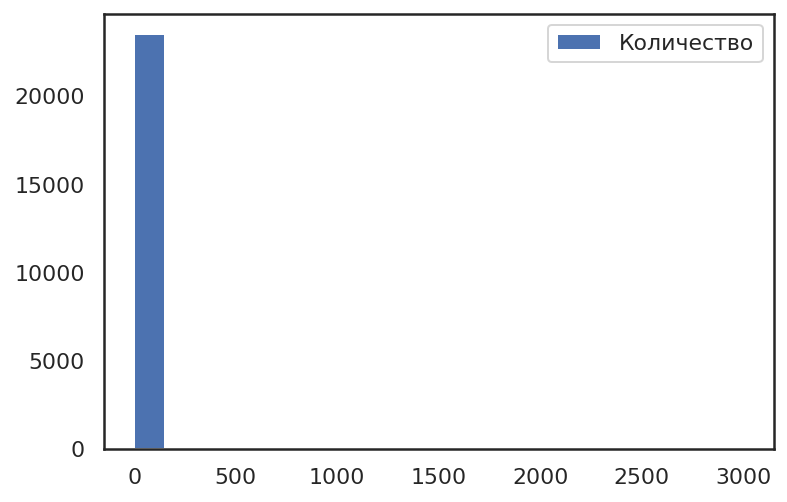


Код cтатуса	: диапазон	0	-	2	среднее значение:	1.227313375633437	разброс:	0.9036682614441086


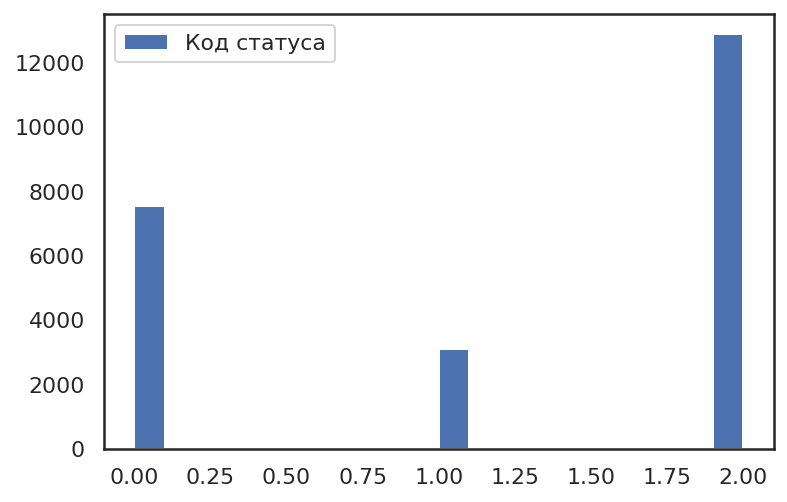


Оплачен ли	: диапазон	0	-	1	среднее значение:	0.910829110420304	разброс:	0.28499024901084186


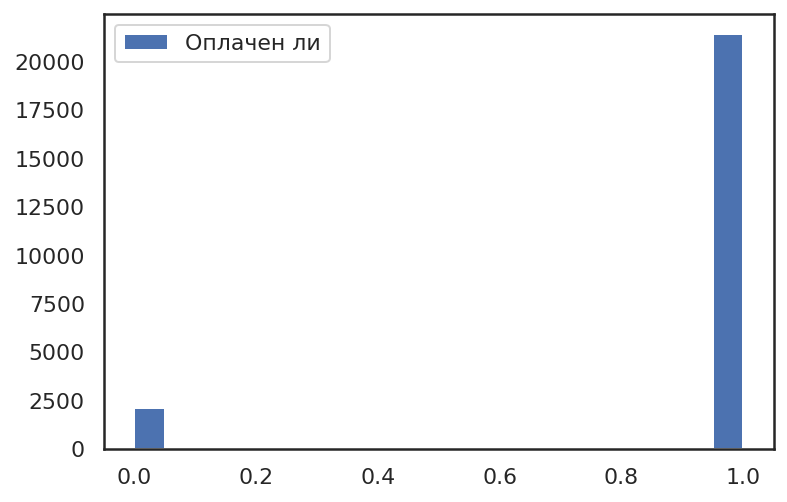

In [ ]:
stats(cluster_data_)  # Выведем информацию о cluster_data

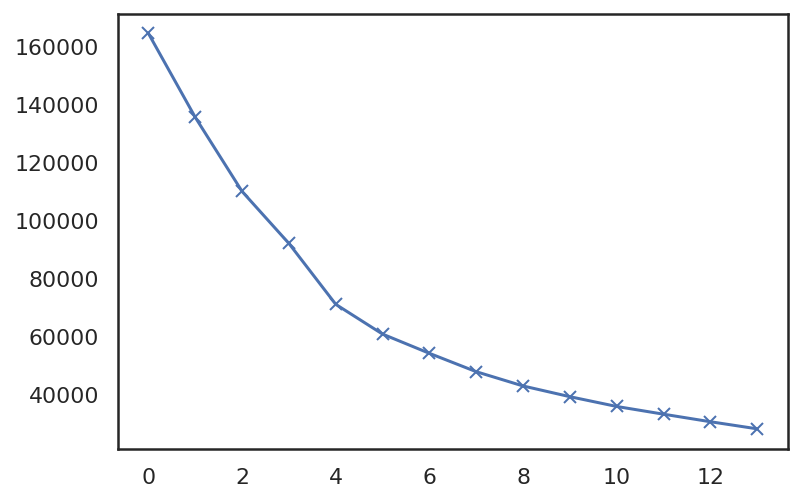

In [ ]:
n_clusters = 15               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1,n_clusters): # Пробегаем по списку от 1 до n_clusters
  kmean = KMeans(i)           # Создаем объект KMeans с i-классами
  kmean.fit(cluster_data_scaled_)   # Проводим классетризацию xTrain01Scaled
  cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot(cost, 'bx-')
plt.show()

Итого: использовать 2, 4, 7 кластеров кажется перспективным

In [ ]:
clusters_count = 4            # Задаем количество кластеров
kmean = KMeans(clusters_count) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(cluster_data_scaled_)     # Произвдим кластеризацию данных xTrain01Scaled
labels = kmean.labels_        # Получаем метки кластеров

In [ ]:
print(labels[:300])            # Выводим первые 20 меток

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


Размер кластера: 2094
в кластер попали:
#########################################

статистические данные по столбцам:
-----------------------------------------
Код покупателя	: диапазон	7	-	1593	среднее значение:	802.7153772683859	разброс:	445.25298302694097


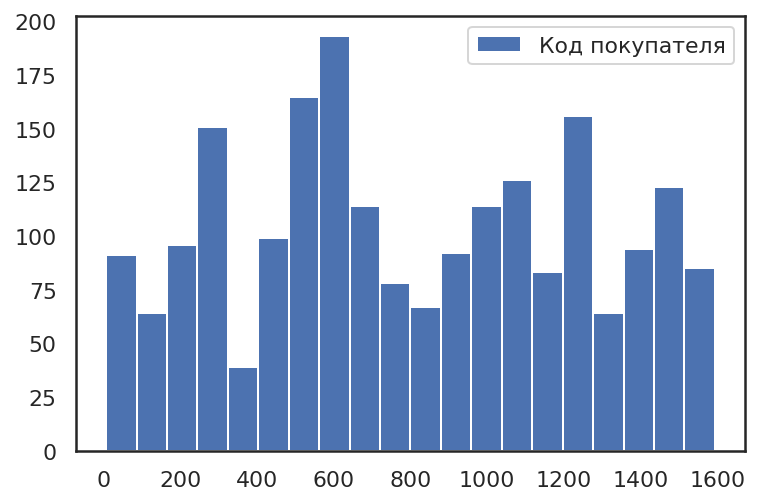


Сумма, руб.	: диапазон	2	-	24745	среднее значение:	4363.150907354346	разброс:	3751.2197473985493


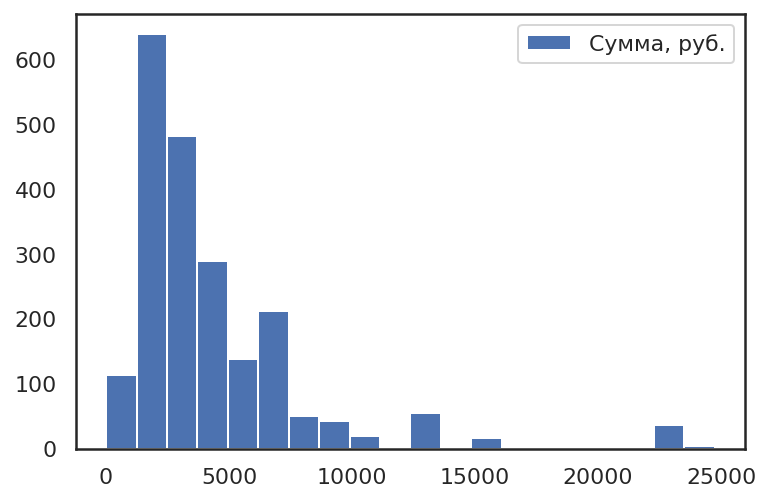


Доставка, руб.	: диапазон	0	-	6036	среднее значение:	1082.922158548233	разброс:	924.8519699595328


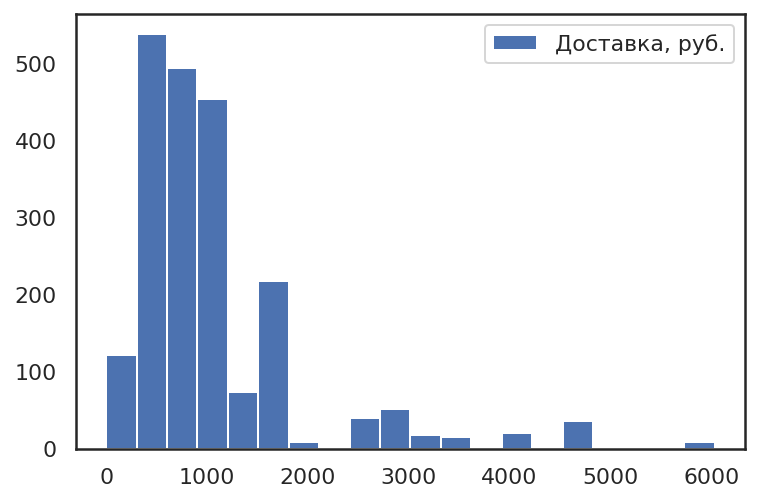


Тип оплаты	: диапазон	0	-	2	среднее значение:	1.001432664756447	разброс:	0.08462429470270695


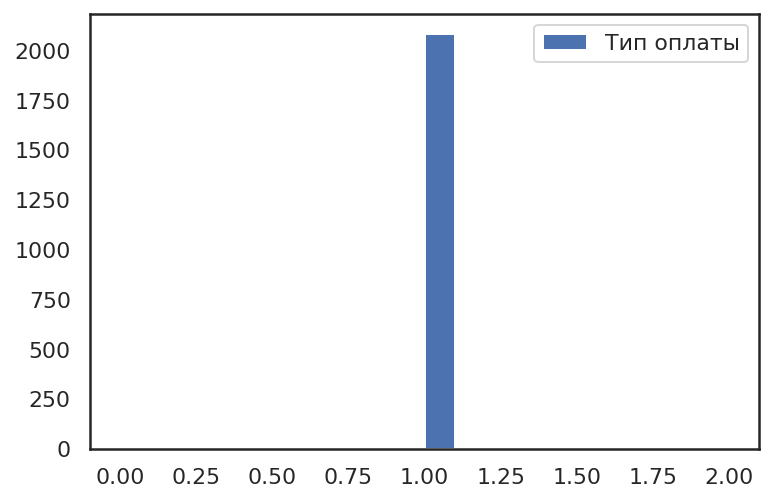


Количество	: диапазон	0	-	3000	среднее значение:	3.1723973256924545	разброс:	65.61638087143469


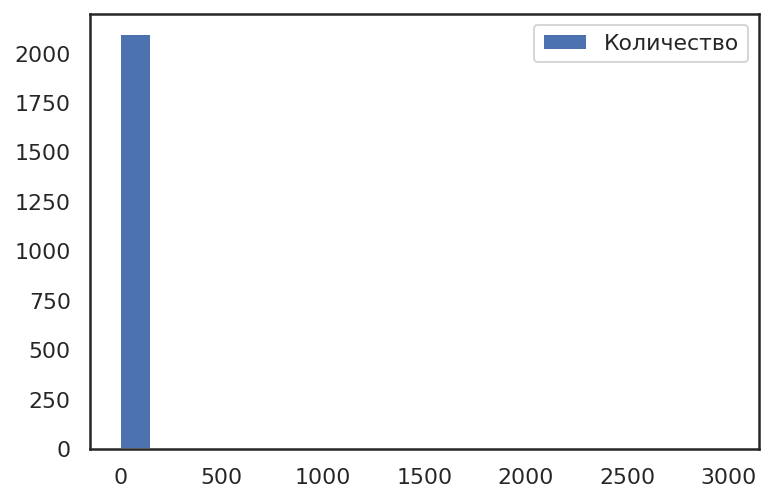


Код cтатуса	: диапазон	0	-	2	среднее значение:	0.24976122254059216	разброс:	0.6018020060968093


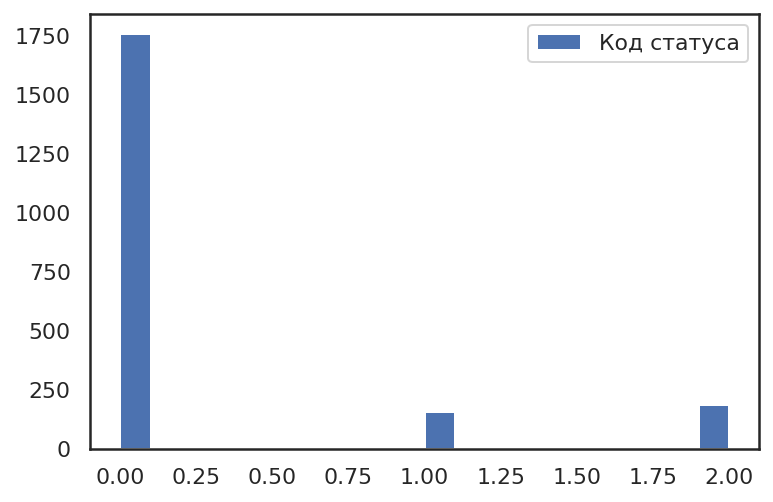


Оплачен ли	: диапазон	0	-	0	среднее значение:	0.0	разброс:	0.0


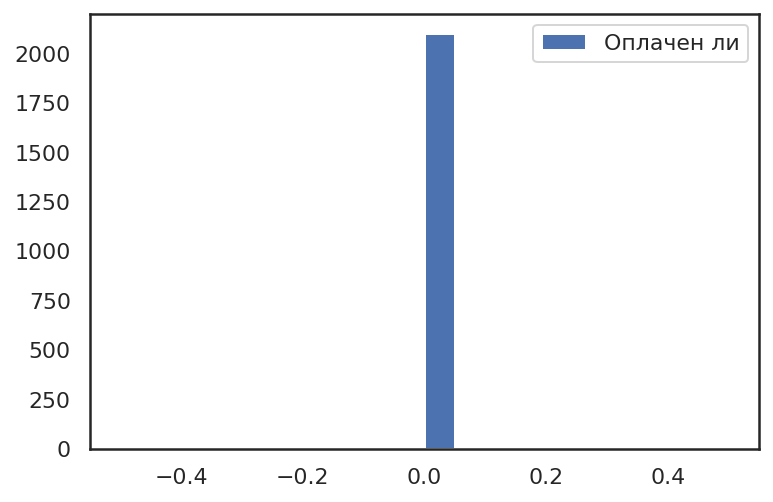

In [ ]:
cluster_number = 0                              # Укажем номер кластера
stats(cluster_data_[labels==cluster_number,:]) # Выведем информацию о кластере с указанным номером

Можно предположить, что в кластер попали покупатели среднего класса и выше по достатку, т.к. разоавые покупки составили от 17 тыс.р., плюс во многих случаях много средств ушло на доставку - в среднем 8 тыс.р.

Вывод: разбивка по кластерам в данном случае интересна с точки зрения сбора сведений о группах покупателей. Изучение поведения и предпочтений может помочь при разработке маркетинговых стратегий.

##Профессиональный

Проведите кластеризацию музыкальных жанров, создав аудио кодировщик. В качестве альтернативы, можно написать любой автокодировщик на датасете, который найдёте самостоятельно и который будет иметь реальные метки, чтобы провести сравнение результатов кластеризации с настоящими метками классов для оценки качества.

####Используем автокодировщик для кластеризации музыкальных композиций по жанрам

Как уже должно быть ясно, это нужно для снижения размерности данных и дополнительного пространственного разделения точек

##### Установка и загрузка необходимых модулей

In [ ]:
# устанавливаем кроссплатформенную open-source библиотеку для обработки видео- и аудиофайлов ffmpeg
!pip install ffmpeg-python # системная команда начинается с "!", pip-установщик, система подобна Linux
!pip install pydub # требуется для успешной загрузки датасета tensorflow

! После установки рекомендуется перезапустить среду выполнения во избежание ошибок запуска ячеек.

In [ ]:
#здесь загружаем нужные библиотеки
import ffmpeg # для работы с аудио
#для работы нейронной сети
import tensorflow as tf
import tensorflow_datasets as tfds # для загрузки датасетов tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, ZeroPadding1D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Conv1DTranspose, Conv1D
from tensorflow.keras.layers import Reshape, Input, MaxPooling2D, Flatten, Lambda, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
#для обработки аудио 
import librosa # библиотека обработки аудио
import librosa.display # вывод графиков средствами librosa
import soundfile as sf # для сохранения аудиофайлов
#лля математической обработки данных
import pandas as pd
import numpy as np
#для вызова прямо в среде программирования команд операционной оболочки
import os
# чтобы можно было добавлять цифры (переменные) в путь
import os.path
from scipy.fft import fft, fftfreq # для преобразования Фурье
#для построения графиков и отрисовки
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn # большая библиотека, нам нужно для работы с Либрозой
from sklearn.utils import resample #для перемешивания выборок
import random  # Для генерации случайных выборок из датасета и для фиксации псевдослучайного деления
random.seed(2) #  фиксация псевдослучайного деления
from sklearn.manifold import TSNE   # для визуализации многомерных данных
from sklearn.cluster import KMeans, SpectralClustering # Импортируем библиотеку KMeans для кластеризации
from sklearn.metrics import accuracy_score, roc_auc_score, homogeneity_score  # импортируем метрики, вторая считается более сбалансированной если есть дисбаланс классов

# загружаем модули чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке и модуль воспроизведения аудио
from IPython.display import HTML, Audio 
from google.colab.output import eval_js # для работы с кодом Javascript 
from base64 import b64decode # модуль для кодировки/раскодировки аудиозаписи(64-разрядный код)
from scipy.io.wavfile import read as wav_read # для чтения WAV формата

import scipy # воспользуемся модулями библиотеки для работы со звуковой дорожкой
import io # input-output, для работы с файлами

import h5py as h5 # для работы с файлами h5
import gc # для удаления неиспользуемых данных

from time import sleep, time # для установки временной паузы в сек. и расчёта времени

#import warnings # удаление предупреждений
#warnings.filterwarnings('ignore')

#####Загрузка и обработка данных

Будем использовать датасет gtzan из набора Tensorflow, для классификации 10 музыкальных жанров.

Citation:

@misc{tzanetakis_essl_cook_2001,
author    = "Tzanetakis, George and Essl, Georg and Cook, Perry",
title     = "Automatic Musical Genre Classification Of Audio Signals",
url       = "http://ismir2001.ismir.net/pdf/tzanetakis.pdf",
publisher = "The International Society for Music Information Retrieval",
year      = "2001"
}

In [ ]:
gc.collect()
X_data1, Y_data1 = tfds.as_numpy(tfds.load( # импортируем аудио данные в виде массива Numpy
    'gtzan',
    split='train',
    batch_size=-1,
    as_supervised=True,
    shuffle_files=True
))

In [ ]:
print(type(X_data1))
print(type(Y_data1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(X_data1.shape)
print(Y_data1.shape)

(1000, 675808)
(1000,)


In [ ]:
Y_data1[0]

7

In [ ]:
# смотрим диапазон данных, они явно не нормализованы
print(X_data1[0].min())
print(X_data1[0].max())

-32768
32767


##### Выводим примеры музыкальных жанров

In [ ]:
classes_dict = {
0:'blues',
1:'classical',
2:'country',
3:'disco',
4:'hiphop',
5:'jazz',
6:'metal',
7:'pop',
8:'reggae',
9:'rock'
}

In [ ]:
classes = classes_dict.keys()
classes

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

При желании можно вывести примеры композиций по классам

In [ ]:
'''
for idx in range(len(classes)): #Проходим по классам
    print('играет жанр:', classes_dict[idx])
    label_indexes = np.where(Y_data1==idx)[0] # Получаем список из индексов положений класса idx в Y_data
    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
    #Выбираем из x_train композицию нужного класса, прослушиваем:
    display(Audio(X_data1[index], rate=22050, autoplay=True))
    sleep(30)
'''
    

"\nfor idx in range(len(classes)): #Проходим по классам\n    print('играет жанр:', classes_dict[idx])\n    label_indexes = np.where(Y_data1==idx)[0] # Получаем список из индексов положений класса idx в Y_data\n    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс\n    #Выбираем из x_train композицию нужного класса, прослушиваем:\n    display(Audio(X_data1[index], rate=22050, autoplay=True))\n    sleep(30)\n"

In [ ]:
X_train_nn = X_data1
Y_train_s = Y_data1

In [ ]:
del X_data1, Y_data1

In [ ]:
# нормализуем данные, на вход функциям Librosa для выделения признаков из аудио должно подаваться 
# нормализованные данные
scaler = MinMaxScaler() # используем функцию нормализации
X_train_s = scaler.fit_transform(X_train_nn) # сначала обучаем на тренировочных данных, потом трансформируем их

In [ ]:
print(X_train_s.shape)
print(Y_train_s.shape)

(1000, 675808)
(1000,)


In [ ]:
print(Y_train_s[0])

7


In [ ]:
mfcc_ = 21 # устанавливаем число мел коэффициентов
sr = 22050 # частота сэмплирования датасета

##### Подпрограммы обработки данных

In [ ]:
#подпрограмма выделения признаков
def get_features(y, sr, mfcc, shuffle):
    #выделяем признаки
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    spec_contr = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_flat = librosa.feature.spectral_flatness(y=y) #, sr=sr
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    #chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    #chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    #yt = librosa.effects.harmonic(y)
    #tonnetz = librosa.feature.tonnetz(y=yt, sr=sr)
    #tempogram = librosa.feature.tempogram(y=y, sr=sr)
    #fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)

    '''
    print('размерности:')
    print('chroma_stft', chroma_stft.shape)
    print('rmse', rmse.shape)
    print('spec_cent', spec_cent.shape)
    print('spec_bw', spec_bw.shape)
    print('rolloff', rolloff.shape)
    print('zcr', zcr.shape)
    print('mfcc', mfcc.shape)
    print('chroma_cqt', chroma_cqt.shape)
    print('chroma_cens', chroma_cens.shape)
    print('melspec', melspec.shape)
    print('spec_contr', spec_contr.shape)
    print('spec_flat', spec_flat.shape)
    print('poly_features', poly_features.shape)
    print('tonnetz', tonnetz.shape)
    print('tempogram', tempogram.shape)
    print('fourier_tempogram', fourier_tempogram.shape)
    '''
    #добавляем признаки в массив, должна получиться матрица чисел размером (количество файлов) х 
    #(общее количество столбцов в признаках)    
    out = np.concatenate((rmse, spec_cent, spec_bw, rolloff, zcr, chroma_stft, 
                          mfcc, melspec, spec_contr, spec_flat, poly_features 
                          ), axis=0) #chroma_cqt, chroma_cens, tonnetz, tempogram
    out1 = np.mean(out, axis = 1)

    return out1


#делаем подпрограмму
#формируем выборки, входные данные сети это X_train, выходные - Y_train
def get_np_data(X_train_s, Y_train_s, mfcc=mfcc_, shuffle = True):
    X_train, Y_train = [], []
    for X, Y in zip(X_train_s, Y_train_s): # берём соответствующие друг другу данные и метки

        out = get_features(X, sr, mfcc, shuffle = shuffle) # получаем усреднённые аудиоданные
        X_train.append(out)
        Y_train.append(utils.to_categorical(Y, len(classes)))
        print(len(Y_train))

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    if shuffle == True:
        X_train, Y_train = resample(X_train, Y_train, random_state=0) # перемешиваем выборки
    y_train_class = np.argmax(Y_train, axis=1)
    X_train = X_train.astype('float32') # переводим входные данные в тип, понятный нейронной сети - с плавающей точкой, 32 разряда
    Y_train = Y_train.astype('float32')
    y_train_class = y_train_class.astype('float32') 
    print(X_train.shape)
    print(Y_train.shape)

    return X_train, Y_train, y_train_class 

##### Создаём и нормируем выборки

In [ ]:
X_train, Y_train, y_train_class = get_np_data(X_train_s, Y_train_s, mfcc=mfcc_, shuffle = False)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных всех признаков
scaler2 = StandardScaler()
#Номируем X_train
X_train_ = scaler2.fit_transform(X_train)

#####Создание и обучение автокодировщика

In [ ]:
def Autoencoder(shape=(X_train.shape[1], 1), latent_dim=40): #40 35 50
    img_input = Input((shape)) 
    x = Dense(16, activation='relu')(img_input)
    x = Flatten()(x)

    z = Dense(latent_dim, name="latent_space", activation='relu')(x)    # вектор, который будет возвращать функция

    x = Dense(176*16, activation='relu')(z)
    x = Reshape((176,16))(x)
    out = Dense(1, activation='relu')(x) 

    model = Model(img_input, out) 
    encoder = Model(img_input, z)

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model, encoder

In [ ]:
seed = 298
tf.random.set_seed(seed)
ae, enc = Autoencoder()
ae.summary()
gc.collect()
history = ae.fit(X_train, X_train, epochs=500, batch_size=4, validation_split=0.1, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 1)]          0         
_________________________________________________________________
dense (Dense)                (None, 176, 16)           32        
_________________________________________________________________
flatten (Flatten)            (None, 2816)              0         
_________________________________________________________________
latent_space (Dense)         (None, 40)                112680    
_________________________________________________________________
dense_1 (Dense)              (None, 2816)              115456    
_________________________________________________________________
reshape (Reshape)            (None, 176, 16)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 176, 1)            17    

Выведем все векторы в скрытом пространстве

In [ ]:
z_train = enc.predict(X_train)
z_train.shape, z_train.std()

((1000, 40), 1045.0034)

#####Разбивка на кластеры

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


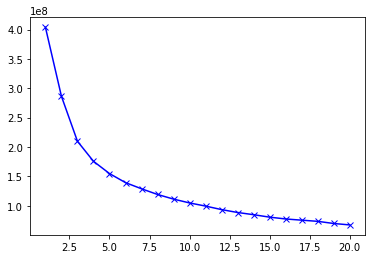

CPU times: user 4.27 s, sys: 3.4 s, total: 7.67 s
Wall time: 4.08 s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

Кривая величины inertia_ показала слабую кластеризацию на 10 кластеров.

#####Оценка верности разбиения

In [ ]:
km = KMeans(10)
km.fit(z_train)

pred = km.predict(z_train)
print('верных ответов',round(100*homogeneity_score(y_train_class, pred),2), '%')

верных ответов 17.07 %


Пробуем улучшить, применив  T-SNE:

In [ ]:
seed = 31
tsne = TSNE(random_state=seed) #17
z_train_tsne = tsne.fit_transform(z_train)

Text(0.5, 1.0, 'AUDIO. t-SNE projection')

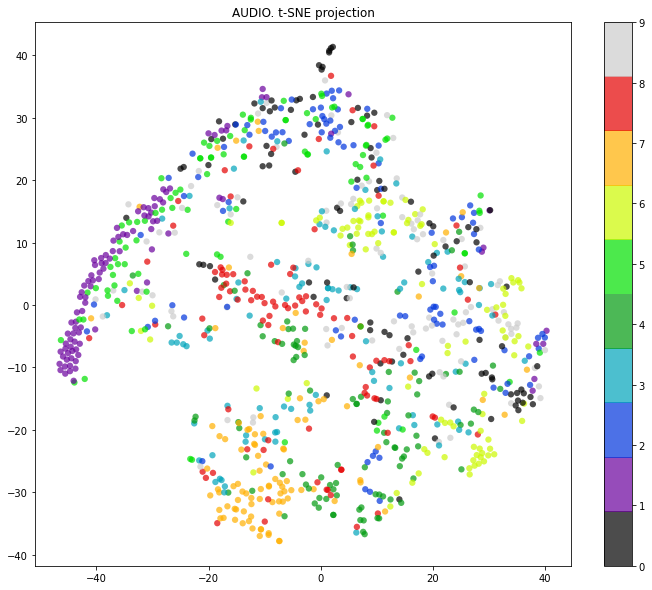

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(z_train_tsne[:, 0], z_train_tsne[:, 1], c=y_train_class, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('AUDIO. t-SNE projection')

Видно, что даже T-SNE далеко не идеально провёл разбивку по классам. Данные слишком разнородны, и над улучшением качества нужно хорошо работать, приложить усилия.

In [ ]:
km = KMeans(10)
km.fit(z_train_tsne)

pred = km.predict(z_train_tsne)
print('верных ответов',round(100*homogeneity_score(y_train_class, pred),2), '%')

верных ответов 23.31 %


Метрика [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) показала слабое совпадение реальных меток с разбиением по кластерам, найденным методом KMeans. С помощью TSNE удалось немного улучшить результат. Нужно понимать, что сама задача не простая - музыкальные композиции очень разнородны, стили частично перекрываются по признакам. Но можно пробовать улучшить результат, задача была только провести кластеризацию - выполнить задание как учебный и не очень простой пример.

#Литература

1. https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering

2. https://habr.com/ru/company/ods/blog/325654/

3. https://datascience.eu/ru/%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5/%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B5-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B-%D0%B8-%D0%B8%D1%85-%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B2-%D0%BC/

4. https://www.machinelearningmastery.ru/unsupervised-machine-learning-clustering-analysis-d40f2b34ae7e/

5. https://proglib.io/p/unsupervised-ml-with-python/

6. https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7

7. http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F

8. http://neerc.ifmo.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F

9. https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC

10. https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82#:~:text=principal%20component%20analysis%2C%20PCA)%20%E2%80%94,%D1%81%D0%B6%D0%B0%D1%82%D0%B8%D1%8F%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C%20%D0%B2%20%D0%BE%D0%B1%D1%89%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D1%85%20%D0%BD%D0%B0%D1%83%D0%BA%D0%B0%D1%85.

11. https://scikit-learn.org/stable/modules/tree.html

12. https://www.machinelearningmastery.ru/scikit-learn-decision-trees-explained-803f3812290d/

13. https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

14. https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms

15. https://scikit-learn.org/stable/modules/clustering.html

